<a href="https://colab.research.google.com/github/ishaanalmeida/stat-arb-mean-reversion/blob/main/stat_arb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Statistical Arbitrage: Mean Reversion in Equity Pairs

In [1]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.15).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [2]:
!git clone https://github.com/ishaanalmeida/stat-arb-mean-reversion.git

Cloning into 'stat-arb-mean-reversion'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (4/4), done.


In [3]:
%cd stat-arb-mean-reversion

/content/stat-arb-mean-reversion


# 1. Project Overview and Hypothesis

In this individual project, I explore a Statistical Arbitrage strategy that leverages mean reversion between two closely related stocks: Visa (V) and Mastercard (MA).

Both companies operate in the digital payments industry and exhibit strong correlation due to their similar business models, market influence, and shared macroeconomic drivers. My goal is to investigate whether their price spread demonstrates stationarity over time, which would make the pair suitable for a mean-reverting long-short strategy.

To do this, I apply cointegration tests (ADF and Johansen) to assess the long-term statistical relationship between the stocks. If cointegration is present, I generate trading signals based on z-score thresholds of the spread and simulate trades using a backtesting engine. The strategy’s performance is then evaluated using metrics such as Sharpe Ratio, CAGR, and maximum drawdown.

## Hypothesis:

If Visa and Mastercard are cointegrated, then any short-term divergence in their price spread is likely to revert to a mean.

Based on this, I hypothesize that a strategy that:

*   Goes long on the undervalued stock (below spread)
*   Goes short on the overvalued stock (above spread)

…can profit when the spread returns to equilibrium.

# 2. Data Collection and Preprocessing

In [9]:
# Import dependencies
!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import matplotlib.pyplot as plt

[*********************100%***********************]  2 of 2 completed


Ticker               V          MA
Date                              
2018-01-02  114.510002  151.910004
2018-01-03  115.650002  153.820007
2018-01-04  116.080002  155.809998
2018-01-05  118.860001  159.039993
2018-01-08  119.339996  159.270004


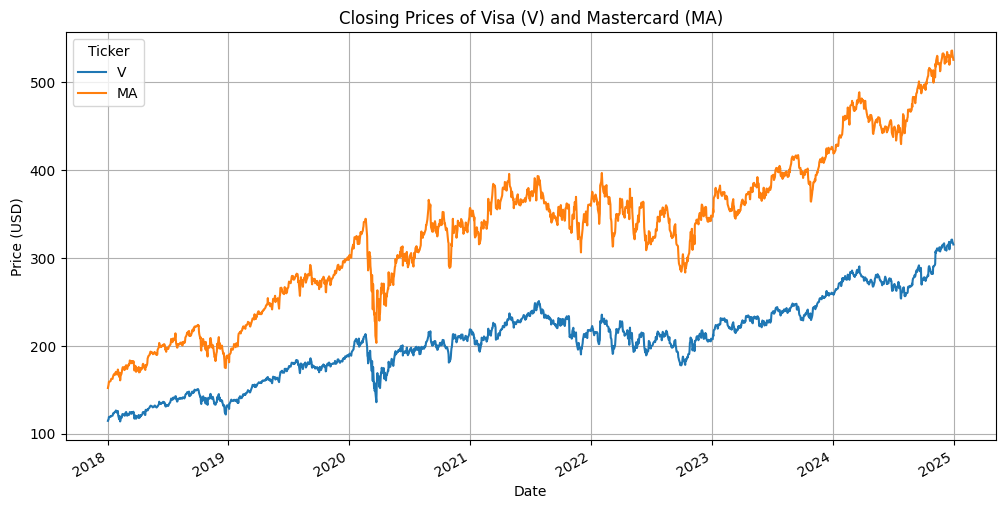

In [6]:
tickers = ['V', 'MA']
start_date = '2018-01-01'
end_date = '2024-12-31'

data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)

# Extract the 'Close' prices instead of 'Adj Close'
close_prices = data['Close'][tickers]

# Drop missing values
close_prices.dropna(inplace=True)

# Preview the data
print(close_prices.head())

# Plot both price series
close_prices.plot(figsize=(12, 6), title='Closing Prices of Visa (V) and Mastercard (MA)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()


# 3. Cointegration Testing (ADF + Johansen)

Hedge ratio (beta) V~MA: 0.8221  | Intercept: 0.5604

Engle–Granger ADF on residuals
ADF stat: -5.340 | p-value: 0.0000
Critical values: {'1%': np.float64(-3.4340922388213175), '5%': np.float64(-2.863192990001633), '10%': np.float64(-2.5676500029387754)}

Johansen (trace) test vs 5% critical values
r <= 0: trace=33.32  | 5% crit=15.49
r <= 1: trace=2.85  | 5% crit=3.84


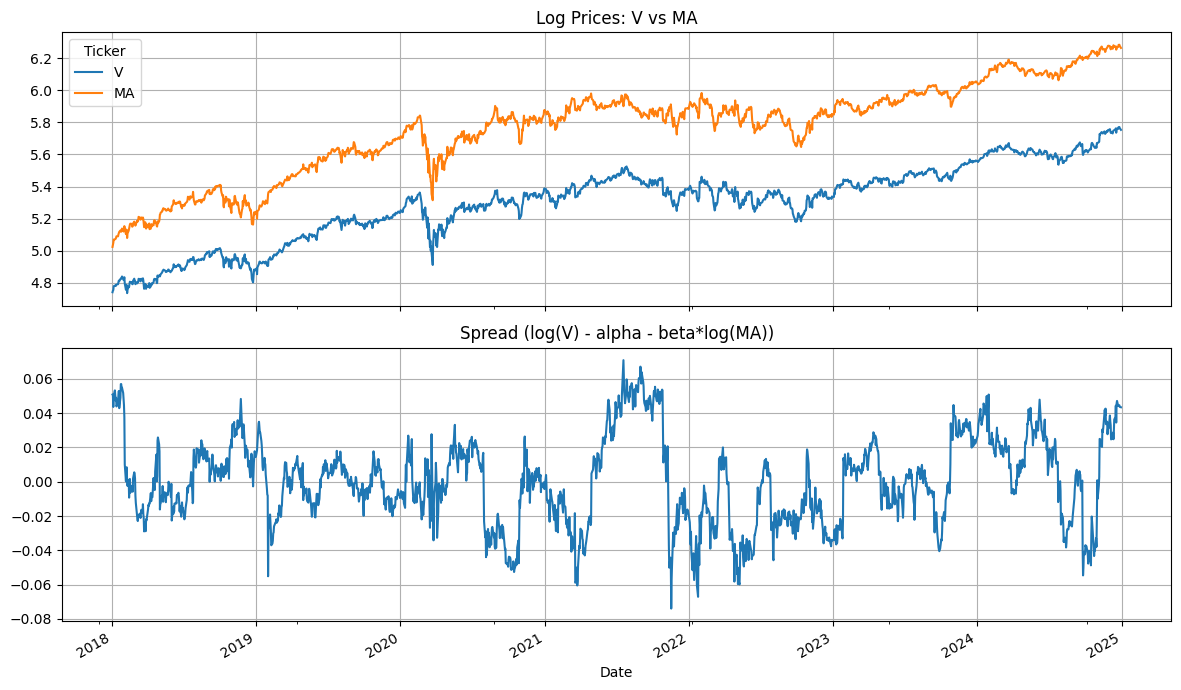


Estimated half-life (days): 17.1


In [10]:
# Use the close_prices DataFrame you already created
df = close_prices.dropna().copy()

# Work in log prices (standard for pairs)
log_df = np.log(df[['V','MA']])

# 1) Engle–Granger: regress V on MA to get hedge ratio and residual (spread)
y = log_df['V']
X = sm.add_constant(log_df['MA'])
eg_model = sm.OLS(y, X).fit()
alpha = eg_model.params['const']
beta  = eg_model.params['MA']

spread = y - (alpha + beta*log_df['MA'])
spread.name = 'spread'

print(f"Hedge ratio (beta) V~MA: {beta:.4f}  | Intercept: {alpha:.4f}")

# ADF on residuals (key test for cointegration)
adf_stat, pval, usedlag, nobs, crit, icbest = adfuller(spread.dropna())
print("\nEngle–Granger ADF on residuals")
print(f"ADF stat: {adf_stat:.3f} | p-value: {pval:.4f}")
print(f"Critical values: {crit}")

# 2) Johansen test (multivariate check)
jres = coint_johansen(log_df[['V','MA']], det_order=0, k_ar_diff=1)
trace_stats = jres.lr1        # trace statistics
crit_vals   = jres.cvt[:,1]   # 5% critical values
print("\nJohansen (trace) test vs 5% critical values")
for i, (ts, cv) in enumerate(zip(trace_stats, crit_vals)):
    print(f"r <= {i}: trace={ts:.2f}  | 5% crit={cv:.2f}")

# Quick visuals
fig, ax = plt.subplots(2,1,figsize=(12,7), sharex=True)
log_df.plot(ax=ax[0], title='Log Prices: V vs MA')
spread.plot(ax=ax[1], title='Spread (log(V) - alpha - beta*log(MA))')
ax[0].grid(True); ax[1].grid(True)
plt.tight_layout(); plt.show()

# Optional: estimate half-life to guide rolling window later
spread_lag = spread.shift(1)
delta = spread - spread_lag
df_hl = pd.concat([delta, spread_lag], axis=1).dropna()
df_hl.columns = ['delta','lag']
hl_model = sm.OLS(df_hl['delta'], sm.add_constant(df_hl['lag'])).fit()
phi = hl_model.params['lag']            # in Δspread = c + φ * spread_{t-1} + ε
halflife = -np.log(2)/np.log(1 + phi) if (1+phi) > 0 else np.nan
print(f"\nEstimated half-life (days): {halflife:.1f}")

# 4. Z-score Calculation and Entry/Exit Logic

In [30]:
# --- 4.0b: Rolling OLS beta (lagged) + blend with constant beta ---
import numpy as np, pandas as pd, statsmodels.api as sm

win = 120      # try 90/120/180 later
lam = 0.5      # blend weight: 0 = pure constant beta, 1 = pure rolling beta

logp = np.log(close_prices[['V','MA']])
idx = logp.index
const = pd.Series(1.0, index=idx, name='const')

alphas, betas = [], []
for i in range(len(idx)):
    if i < win:
        alphas.append(np.nan); betas.append(np.nan); continue
    y = logp['V'].iloc[i-win+1:i+1]
    X = pd.concat([const.iloc[i-win+1:i+1], logp['MA'].iloc[i-win+1:i+1]], axis=1)
    res = sm.OLS(y, X).fit()
    alphas.append(res.params['const']); betas.append(res.params['MA'])

alpha_rb = pd.Series(alphas, index=idx, name='alpha_rb')
beta_rb  = pd.Series(betas,  index=idx, name='beta_rb')

# Constant beta from Engle–Granger (already computed earlier as `beta`)
beta_const = pd.Series(beta, index=idx, name='beta_const')

# Blend & LAG by 1 bar for trading (use beta estimated up to t-1 for returns at t)
beta_blend = (lam * beta_rb + (1 - lam) * beta_const).shift(1)

# Build spread with the **non-lagged** alpha/beta for z-score construction (information up to t)
# and then align start where both alpha_rb & beta_rb exist
spread_blend = logp['V'] - (alpha_rb + (lam * beta_rb + (1 - lam) * beta_const) * logp['MA'])
valid_start = max(spread_blend.first_valid_index(), beta_blend.first_valid_index())
spread_blend = spread_blend.loc[valid_start:]
beta_blend   = beta_blend.loc[valid_start:]

print(f"Blended beta ready from {valid_start.date()} | lam={lam}, window={win}")

λ=0.25, win=90 -> Sharpe 0.49
λ=0.25, win=120 -> Sharpe 0.48
λ=0.25, win=180 -> Sharpe -0.03
λ=0.5, win=90 -> Sharpe 0.51
λ=0.5, win=120 -> Sharpe 0.52
λ=0.5, win=180 -> Sharpe 0.04
λ=0.75, win=90 -> Sharpe 0.55
λ=0.75, win=120 -> Sharpe 0.32
λ=0.75, win=180 -> Sharpe -0.06


[BLENDED] win=180, λ=0.75 | lookback=60, z_entry=1.8, z_exit=0.7
Sharpe (net): 0.52 | CAGR: 3.55% | MaxDD: -7.71%


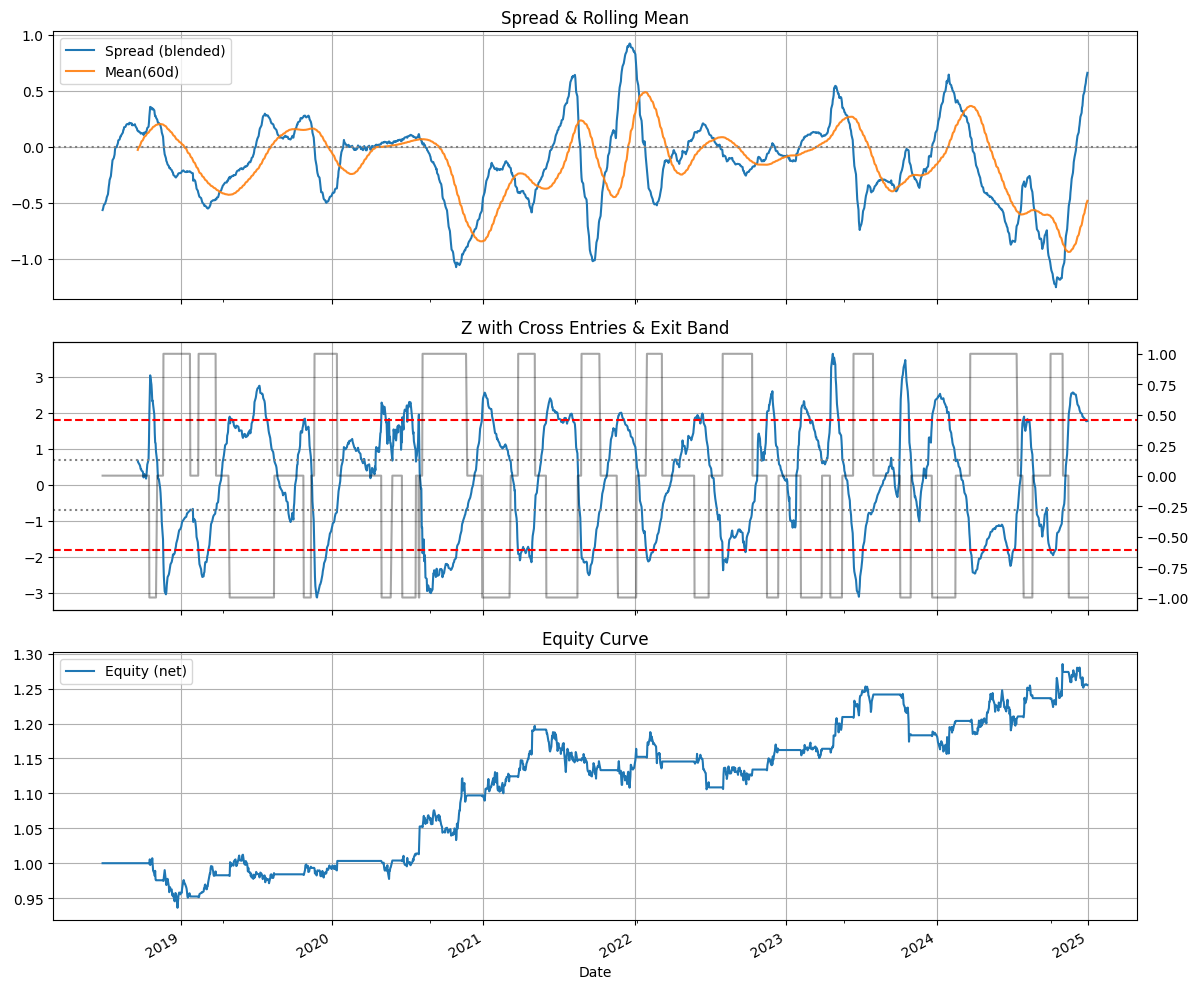

In [31]:
# --- 4.1 FINAL: Signals + Backtest (uses rolling beta/spread if available) ---
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# Choose adaptive series if present; else fall back to constant beta setup
if 'spread_blend' in globals() and 'beta_blend' in globals() and not spread_blend.dropna().empty:
    spread_use = spread_blend.copy()
    beta_use   = beta_blend.copy()
else:
    spread_use = spread.copy()
    beta_use   = pd.Series(beta, index=np.log(close_prices[['V','MA']]).index).shift(1)  # lag constant beta 1 bar for symmetry
    spread_use = spread_use.loc[beta_use.first_valid_index():]
    beta_use   = beta_use.loc[spread_use.index[0]:]

# Params (your tuned values)
lookback     = 60
z_entry      = 1.8
z_exit       = 0.7
cost_per_leg = 0.0005

# Rolling z-score on the chosen spread
m = spread_use.rolling(lookback).mean()
s = spread_use.rolling(lookback).std()
z = (spread_use - m) / s
z = z.replace([np.inf, -np.inf], np.nan)

# Cross-entry, fixed sizing
pos = pd.Series(0.0, index=z.index, name='position')
for i in range(1, len(z)):
    zprev, znow = z.iloc[i-1], z.iloc[i]
    cur = pos.iloc[i-1]; new = cur
    if cur != 0.0:
        if abs(znow) < z_exit: new = 0.0
    else:
        if (zprev <  z_entry) and (znow >=  z_entry): new = -1.0
        elif (zprev > -z_entry) and (znow <= -z_entry): new = +1.0
    pos.iloc[i] = new

# Returns with matched/lagged beta
logr = np.log(close_prices[['V','MA']]).diff()
logr  = logr.loc[z.index[0]:]                # align
beta_use = beta_use.reindex(logr.index).ffill()
spread_ret = logr['V'] - beta_use * logr['MA']

# PnL
p_ret_gross = pos.shift(1).reindex(spread_ret.index).fillna(0.0) * spread_ret
turnover    = pos.reindex(spread_ret.index).diff().abs().fillna(0.0)
p_ret_net   = p_ret_gross - turnover * (2 * cost_per_leg)
equity      = (1 + p_ret_net.fillna(0.0)).cumprod()

# Metrics
ann = 252
def sharpe(ser):
    mu, sd = ser.mean(), ser.std(ddof=0)
    return np.sqrt(ann)*(mu/sd) if sd>0 else np.nan
def cagr(eq):
    years = (eq.index[-1]-eq.index[0]).days/365.25
    return (eq.iloc[-1])**(1/years)-1 if years>0 else np.nan
def max_dd(eq):
    dd = eq/eq.cummax()-1.0
    return dd.min(), dd

SR = sharpe(p_ret_net.dropna()); CAGR = cagr(equity); MDD, _ = max_dd(equity)
print(f"[BLENDED] win={win}, λ={lam} | lookback={lookback}, z_entry={z_entry}, z_exit={z_exit}")
print(f"Sharpe (net): {SR:.2f} | CAGR: {CAGR:.2%} | MaxDD: {MDD:.2%}")

# Plots
fig, ax = plt.subplots(3,1,figsize=(12,10), sharex=True)
spread_use.plot(ax=ax[0], label='Spread (blended)' if 'spread_blend' in globals() else 'Spread')
m.plot(ax=ax[0], label=f'Mean({lookback}d)', alpha=0.9)
ax[0].axhline(0, ls=':', c='gray'); ax[0].legend(); ax[0].grid(True); ax[0].set_title('Spread & Rolling Mean')

z.plot(ax=ax[1], label='Z-score')
for h in [z_entry,-z_entry,z_exit,-z_exit]:
    ax[1].axhline(h, ls='--' if abs(h)==z_entry else ':', c='red' if abs(h)==z_entry else 'gray')
pos.plot(ax=ax[1], secondary_y=True, color='black', alpha=0.35, label='Position')
ax[1].grid(True); ax[1].set_title('Z with Cross Entries & Exit Band')

equity.plot(ax=ax[2], label='Equity (net)'); ax[2].grid(True); ax[2].legend(); ax[2].set_title('Equity Curve')
plt.tight_layout(); plt.show()


In [32]:
# --- 4.2c: Completed-trade diagnostics (robust) ---
# Uses `pos` and `p_ret_net` from 4.1/4.1b

import numpy as np
import pandas as pd

# Identify entries (0 -> nonzero) and exits (nonzero -> 0)
entry_sig = (pos.shift(1).fillna(0) == 0) & (pos != 0)
exit_sig  = (pos.shift(1) != 0) & (pos == 0)

entries = pos.index[entry_sig]
exits   = pos.index[exit_sig]

# If an exit occurs before the first entry, drop that first exit
if len(exits) and len(entries) and exits[0] <= entries[0]:
    exits = exits[1:]

# Align pairs and drop any trailing open trade
n = min(len(entries), len(exits))
entries = entries[:n]
exits   = exits[:n]

trade_pnls = []
trade_sides = []
trade_holds = []

idx = p_ret_net.index
for s, e in zip(entries, exits):
    # Because we trade on the next bar (pos.shift(1)), PnL starts the bar AFTER entry.
    s_i = idx.get_indexer([s])[0] + 1
    e_i = idx.get_indexer([e])[0]      # include the exit bar (contains exit cost)
    if s_i <= e_i:
        seg = p_ret_net.iloc[s_i:e_i+1]
        trade_pnls.append(seg.sum())
        trade_holds.append(len(seg))
        trade_sides.append(np.sign(pos.loc[s]))

trade_pnls = pd.Series(trade_pnls, index=range(len(trade_pnls)))
trade_holds = pd.Series(trade_holds, index=trade_pnls.index)
trade_sides = pd.Series(trade_sides, index=trade_pnls.index)

print(f"Completed trades: {len(trade_pnls)}")
if len(trade_pnls):
    print(f"Win rate: {(trade_pnls > 0).mean():.1%}")
    print(f"Avg hold: {trade_holds.mean():.1f} days | Median: {trade_holds.median():.0f} days")
    print(f"Avg trade PnL (net): {trade_pnls.mean():.5f} | Median: {trade_pnls.median():.5f}")
    print(f"Long/Short mix: { (trade_sides>0).mean():.1%} long-spread, {(trade_sides<0).mean():.1%} short-spread")

Completed trades: 27
Win rate: 74.1%
Avg hold: 33.0 days | Median: 29 days
Avg trade PnL (net): 0.01058 | Median: 0.01130
Long/Short mix: 40.7% long-spread, 59.3% short-spread


In [26]:
# --- 4.3 QUICK WIN: Cost sensitivity ---
cost_grid = [0.0000, 0.0002, 0.0005, 0.0010]  # 0, 2, 5, 10 bps per leg
for c in cost_grid:
    p = (pos.shift(1).reindex(spread_ret.index).fillna(0.0) * spread_ret) \
        - pos.reindex(spread_ret.index).diff().abs().fillna(0.0) * (2*c)
    sh = np.sqrt(252) * p.mean() / p.std()
    print(f"Costs {int(c*1e4)} bps/leg -> Sharpe {sh:.2f}")


Costs 0 bps/leg -> Sharpe 0.64
Costs 2 bps/leg -> Sharpe 0.59
Costs 5 bps/leg -> Sharpe 0.52
Costs 10 bps/leg -> Sharpe 0.40


In [33]:
fig.savefig('fig_spread_mean.png', dpi=180, bbox_inches='tight')
plt.close(fig)

# 5. Backtesting the Strategy

In [55]:
# --- 5.1: helper backtest used inside the walk-forward loop ---
import numpy as np
import pandas as pd

def backtest_cross_entry(
    spread_series: pd.Series,   # spread used to compute z-score (may include train "tail" for warm-up)
    lookback: int,              # rolling window for mean/std in z-score
    z_entry: float,             # enter when |z| crosses this level from inside
    z_exit: float,              # fully exit when |z| drops below this band
    r_V: pd.Series,             # TEST-window log-returns of V
    r_MA: pd.Series,            # TEST-window log-returns of MA
    beta_for_returns,           # float or Series aligned to TEST index (used to form daily spread returns)
    cost_per_leg: float = 0.0005
):
    """
    Returns:
      p_ret_net : TEST-window net daily P&L series
      pos_test  : TEST-window position (−1/0/+1)
      z_test    : z-score aligned to the TEST-window index
    """
    # 1) z-score on the supplied spread (train tail + test) so rolling stats are warm
    m = spread_series.rolling(lookback).mean()
    s = spread_series.rolling(lookback).std()
    z = (spread_series - m) / s
    z = z.replace([np.inf, -np.inf], np.nan)

    # 2) Threshold-cross entries with hysteresis (exit band). Fixed sizing (±1).
    pos = pd.Series(0.0, index=z.index, name="position")
    for i in range(1, len(z)):
        z_prev, z_now = z.iloc[i-1], z.iloc[i]
        cur = pos.iloc[i-1]
        new = cur

        if cur != 0.0:
            # When inside the exit band, flatten (reduces churn around thresholds).
            if abs(z_now) < z_exit:
                new = 0.0
        else:
            # Only enter when we CROSS from neutral -> outside the entry band.
            if (z_prev <  z_entry) and (z_now >=  z_entry):
                new = -1.0  # short spread: short V, long β·MA
            elif (z_prev > -z_entry) and (z_now <= -z_entry):
                new = +1.0  # long spread: long V, short β·MA

        pos.iloc[i] = new

    # 3) Build TEST spread returns using supplied β (constant or time-varying).
    if isinstance(beta_for_returns, (float, int, np.floating)):
        beta_series = pd.Series(float(beta_for_returns), index=r_V.index)
    else:
        beta_series = pd.Series(beta_for_returns).reindex(r_V.index).ffill()

    spread_ret = r_V - beta_series * r_MA

    # 4) Align to TEST index and compute next-bar P&L with transaction costs.
    pos_test    = pos.reindex(spread_ret.index)
    p_ret_gross = pos_test.shift(1).fillna(0.0) * spread_ret   # execute on next bar
    turnover    = pos_test.diff().abs().fillna(0.0)            # counts regime changes
    p_ret_net   = p_ret_gross - turnover * (2 * cost_per_leg)  # 2 legs per switch

    return p_ret_net, pos_test, z.reindex(spread_ret.index)


[WF tuned+gated] Sharpe: 0.57 | CAGR: 1.57% | MaxDD: -2.69% | OOS days: 1197


,train_start,train_end,test_start,test_end,L,Ein,Eout,beta,train_sharpe,adf_p
0,2018-01-03,2020-01-03,2020-01-06,2020-04-03,60.0,1.8,0.7,0.795169,1.074770,0.003467
1,2018-04-05,2020-04-03,2020-04-06,2020-07-06,40.0,1.6,0.9,0.805200,1.325253,0.008535
2,2018-07-05,2020-07-06,2020-07-07,2020-10-02,60.0,2.0,0.7,0.801263,1.715039,0.001635
3,2018-10-03,2020-10-02,2020-10-05,2021-01-04,50.0,1.6,0.7,0.781446,1.246265,0.011521
4,2019-01-04,2021-01-04,2021-01-05,2021-04-06,70.0,2.0,0.9,0.792772,1.645961,0.002365


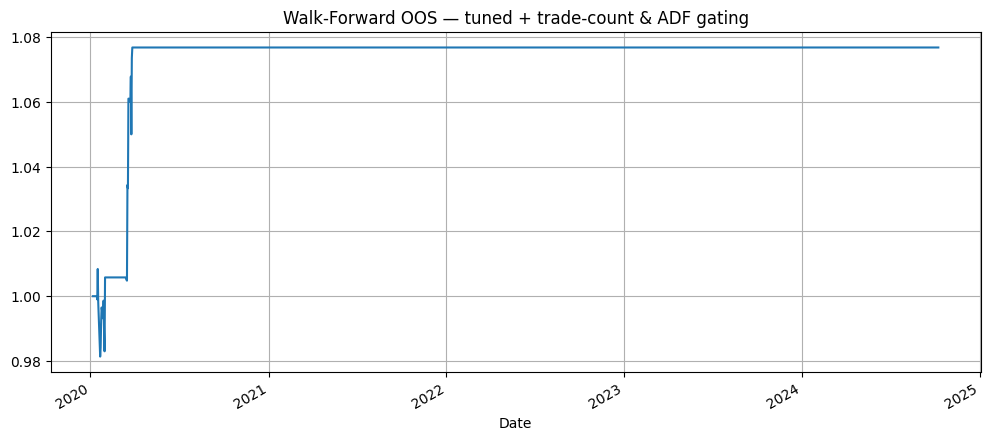

In [56]:
# --- 5.2: Walk-Forward with richer tuning, trade-count constraint, and ADF gating ---
import numpy as np, pandas as pd, statsmodels.api as sm, matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from IPython.display import display

# Assumes `close_prices[['V','MA']]` exists from earlier steps
logp_all = np.log(close_prices[['V','MA']])
ret_all  = logp_all.diff().dropna()

# ---- WF config ----
train_days   = 252 * 2                    # ~2 years train
test_days    = 63                         # ~3 months OOS (disjoint blocks)
param_grid   = {                          # robust but compact grid
    "lookback": [40, 50, 60, 70],
    "z_entry":  [1.6, 1.8, 2.0],
    "z_exit":   [0.5, 0.7, 0.9],
}
min_trades_on_train = 2                   # reject combos that barely trade on TRAIN
gate_by_adf = True                        # require residual stationarity on TRAIN
cost_per_leg = 0.0005

# ---- helper: build positions on TRAIN and return (Sharpe, completed_trades) ----
def _train_score(spread_tr: pd.Series, rV_tr: pd.Series, rMA_tr: pd.Series,
                 beta_tr: float, L: int, Ein: float, Eout: float):
    m = spread_tr.rolling(L).mean()
    s = spread_tr.rolling(L).std()
    z = (spread_tr - m)/s
    z = z.replace([np.inf, -np.inf], np.nan)

    pos = pd.Series(0.0, index=z.index)
    for i in range(1, len(z)):
        zprev, znow = z.iloc[i-1], z.iloc[i]
        cur = pos.iloc[i-1]; new = cur
        if cur != 0:
            if abs(znow) < Eout: new = 0.0
        else:
            if (zprev <  Ein) and (znow >=  Ein): new = -1.0
            elif (zprev > -Ein) and (znow <= -Ein): new = +1.0
        pos.iloc[i] = new

    # Completed trades ≈ min(entries, exits)
    entries = ((pos.shift(1).fillna(0) == 0) & (pos != 0)).sum()
    exits   = ((pos.shift(1) != 0) & (pos == 0)).sum()
    trades  = int(min(entries, exits))

    p = pos.shift(1).fillna(0.0) * (rV_tr - beta_tr*rMA_tr)
    p = p - pos.diff().abs().fillna(0.0) * (2*cost_per_leg)

    vol = p.std(ddof=0)
    sh  = np.sqrt(252)*p.mean()/vol if vol > 0 else -np.inf
    return sh, trades

# ---- walk-forward loop (disjoint quarters) ----
oos_chunks, chosen_rows = [], []
train_end_idx = train_days - 1

while True:
    test_start_idx = train_end_idx + 1
    test_end_idx   = test_start_idx + test_days - 1
    if test_end_idx >= len(ret_all): break

    train_start_idx = train_end_idx - train_days + 1
    t0 = ret_all.index[train_start_idx]; t1 = ret_all.index[train_end_idx]
    u0 = ret_all.index[test_start_idx];  u1 = ret_all.index[test_end_idx]

    # 1) Estimate β on TRAIN only (OLS on logs)
    y_tr = logp_all['V'].iloc[train_start_idx:train_end_idx+1]
    X_tr = sm.add_constant(logp_all['MA'].iloc[train_start_idx:train_end_idx+1])
    eg   = sm.OLS(y_tr, X_tr).fit()
    a_tr = float(eg.params['const']); b_tr = float(eg.params['MA'])

    # 2) ADF gate on TRAIN residual (optional)
    pval = np.nan
    if gate_by_adf:
        resid_tr = y_tr - (a_tr + b_tr*X_tr['MA'])
        try:
            adf_stat, pval, *_ = adfuller(resid_tr.dropna())
        except Exception:
            pval = 1.0
        # If not stationary at 10%, skip this quarter (stay flat)
        if pval > 0.10:
            oos_chunks.append(pd.Series(0.0, index=ret_all.index[test_start_idx:test_end_idx+1]))
            chosen_rows.append({"train_start": t0, "train_end": t1, "test_start": u0, "test_end": u1,
                                "L": None, "Ein": None, "Eout": None, "beta": b_tr,
                                "train_sharpe": np.nan, "adf_p": pval})
            train_end_idx = test_end_idx
            continue

    # Build spread over TRAIN+TEST for z-score warm-up
    spread_all = (logp_all['V'] - (a_tr + b_tr*logp_all['MA'])) \
                   .iloc[train_start_idx:test_end_idx+1]
    rV_tr = ret_all['V'].iloc[train_start_idx:train_end_idx+1]
    rMA_tr = ret_all['MA'].iloc[train_start_idx:train_end_idx+1]
    rV_ts = ret_all['V'].iloc[test_start_idx:test_end_idx+1]
    rMA_ts = ret_all['MA'].iloc[test_start_idx:test_end_idx+1]

    # 3) Tune params on TRAIN with trade-count constraint
    best = (-np.inf, (None,None,None))
    for L in param_grid["lookback"]:
        spread_tr = spread_all.iloc[:len(rV_tr)]
        for Ein in param_grid["z_entry"]:
            for Eout in param_grid["z_exit"]:
                sh, trades = _train_score(spread_tr, rV_tr, rMA_tr, b_tr, L, Ein, Eout)
                if trades < min_trades_on_train:
                    continue
                if sh > best[0]:
                    best = (sh, (L, Ein, Eout))
    L_opt, Ein_opt, Eout_opt = best[1]

    # If nothing met the rule, stay flat this quarter
    if L_opt is None:
        oos_chunks.append(pd.Series(0.0, index=ret_all.index[test_start_idx:test_end_idx+1]))
        chosen_rows.append({"train_start": t0, "train_end": t1, "test_start": u0, "test_end": u1,
                            "L": None, "Ein": None, "Eout": None, "beta": b_tr,
                            "train_sharpe": np.nan, "adf_p": pval})
        train_end_idx = test_end_idx
        continue

    # 4) Trade TEST with tuned params & TRAIN β (with warm-up so z is defined day-1)
    warm = max(0, L_opt - 1)
    span_start_idx = max(train_start_idx, test_start_idx - warm)
    spread_for_test_z = spread_all.iloc[span_start_idx:test_end_idx+1]

    p_ts, pos_ts, _ = backtest_cross_entry(
        spread_series=spread_for_test_z,
        lookback=L_opt, z_entry=Ein_opt, z_exit=Eout_opt,
        r_V=rV_ts, r_MA=rMA_ts, beta_for_returns=b_tr,
        cost_per_leg=cost_per_leg
    )
    oos_chunks.append(p_ts)
    chosen_rows.append({"train_start": t0, "train_end": t1, "test_start": u0, "test_end": u1,
                        "L": L_opt, "Ein": Ein_opt, "Eout": Eout_opt, "beta": b_tr,
                        "train_sharpe": best[0], "adf_p": pval})

    # 5) Advance by a full TEST block (disjoint quarters)
    train_end_idx = test_end_idx

# ---- Stitch + summarize ----
oos_pnl = pd.concat(oos_chunks).sort_index()
oos_params_df = pd.DataFrame(chosen_rows)

ann = 252
sr  = np.sqrt(ann)*oos_pnl.mean()/oos_pnl.std(ddof=0)
yrs = (oos_pnl.index[-1]-oos_pnl.index[0]).days/365.25
cagr = (1+oos_pnl).prod()**(1/yrs) - 1
eq   = (1+oos_pnl).cumprod()
mdd  = (eq/eq.cummax()-1).min()

print(f"[WF tuned+gated] Sharpe: {sr:.2f} | CAGR: {cagr:.2%} | MaxDD: {mdd:.2%} | OOS days: {len(oos_pnl)}")
display(oos_params_df.head())

ax = eq.plot(figsize=(12,5), title="Walk-Forward OOS — tuned + trade-count & ADF gating")
ax.grid(True); plt.show()


[WF Fixed Params] L=60, Ein=1.8, Eout=0.7
Sharpe: 0.57 | CAGR: 1.57% | MaxDD: -2.69% | OOS days: 1197


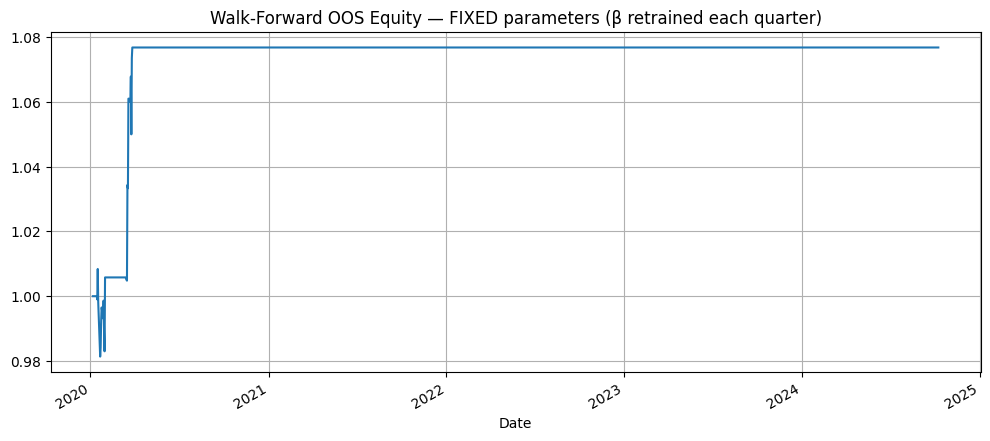

In [57]:
# --- 5.3: Walk-Forward using FIXED thresholds (β retrained quarterly) ---
import numpy as np, pandas as pd, statsmodels.api as sm, matplotlib.pyplot as plt

# Inputs (reuse from above)
logp_all = np.log(close_prices[['V','MA']])
ret_all  = logp_all.diff().dropna()

# Fixed thresholds (use your tuned baseline)
L_fixed, Ein_fixed, Eout_fixed = 60, 1.8, 0.7
cost_per_leg = 0.0005
train_days, test_days = 252*2, 63

oos_chunks_fixed, rows_fixed = [], []
train_end_idx = train_days - 1

while True:
    test_start_idx = train_end_idx + 1
    test_end_idx   = test_start_idx + test_days - 1
    if test_end_idx >= len(ret_all): break

    train_start_idx = train_end_idx - train_days + 1
    t0 = ret_all.index[train_start_idx]; t1 = ret_all.index[train_end_idx]
    u0 = ret_all.index[test_start_idx];  u1 = ret_all.index[test_end_idx]

    # β on TRAIN
    y_tr = logp_all['V'].iloc[train_start_idx:train_end_idx+1]
    X_tr = sm.add_constant(logp_all['MA'].iloc[train_start_idx:train_end_idx+1])
    eg   = sm.OLS(y_tr, X_tr).fit()
    a_tr = float(eg.params['const']); b_tr = float(eg.params['MA'])

    spread_all = (logp_all['V'] - (a_tr + b_tr*logp_all['MA'])) \
                   .iloc[train_start_idx:test_end_idx+1]
    rV_ts = ret_all['V'].iloc[test_start_idx:test_end_idx+1]
    rMA_ts = ret_all['MA'].iloc[test_start_idx:test_end_idx+1]

    warm = max(0, L_fixed - 1)
    span_start_idx = max(train_start_idx, test_start_idx - warm)
    spread_for_test_z = spread_all.iloc[span_start_idx:test_end_idx+1]

    p_ts, pos_ts, _ = backtest_cross_entry(
        spread_series=spread_for_test_z,
        lookback=L_fixed, z_entry=Ein_fixed, z_exit=Eout_fixed,
        r_V=rV_ts, r_MA=rMA_ts, beta_for_returns=b_tr,
        cost_per_leg=cost_per_leg
    )

    oos_chunks_fixed.append(p_ts)
    rows_fixed.append({"train_start": t0, "train_end": t1, "test_start": u0, "test_end": u1,
                       "L": L_fixed, "Ein": Ein_fixed, "Eout": Eout_fixed, "beta": b_tr})

    train_end_idx = test_end_idx  # disjoint blocks

# Stitch + metrics
oos_fixed = pd.concat(oos_chunks_fixed).sort_index()
ann = 252
sr = np.sqrt(ann)*oos_fixed.mean()/oos_fixed.std(ddof=0)
yrs = (oos_fixed.index[-1]-oos_fixed.index[0]).days/365.25
cagr = (1+oos_fixed).prod()**(1/yrs) - 1
eq = (1+oos_fixed).cumprod()
mdd = (eq/eq.cummax()-1).min()

print(f"[WF Fixed Params] L={L_fixed}, Ein={Ein_fixed}, Eout={Eout_fixed}")
print(f"Sharpe: {sr:.2f} | CAGR: {cagr:.2%} | MaxDD: {mdd:.2%} | OOS days: {len(oos_fixed)}")

ax = eq.plot(figsize=(12,5), title="Walk-Forward OOS Equity — FIXED parameters (β retrained each quarter)")
ax.grid(True); plt.show()


In [58]:
# --- 5.4: Per-segment diagnostics for the re-tuned WF (5.2) ---
import numpy as np, pandas as pd

if 'oos_params_df' in globals() and not oos_params_df.empty:
    diag_rows = []
    for _, row in oos_params_df.iterrows():
        # Skip segments where we stayed flat (no chosen params)
        if pd.isna(row['L']):
            diag_rows.append({
                "test_start": row['test_start'], "test_end": row['test_end'],
                "trades": 0, "L": None, "Ein": None, "Eout": None,
                "seg_Sharpe": np.nan, "exposed_days": 0
            })
            continue

        # Rebuild positions quickly for this TEST segment with chosen params (coarse count)
        L = int(row['L']); Ein = float(row['Ein']); Eout = float(row['Eout']); b = float(row['beta'])
        u0, u1 = pd.Timestamp(row['test_start']), pd.Timestamp(row['test_end'])

        # Slice needed inputs
        logp = np.log(close_prices[['V','MA']])
        ret  = logp.diff().dropna()
        spread = (logp['V'] - (b*logp['MA']))  # α cancels in z-score; fine for diagnostics
        # Warm-up
        start_idx = max(0, spread.index.get_indexer([u0])[0] - (L-1))
        end_idx   = spread.index.get_indexer([u1])[0]
        spread_seg = spread.iloc[start_idx:end_idx+1]

        # z-score & positions
        m = spread_seg.rolling(L).mean()
        s = spread_seg.rolling(L).std()
        z = (spread_seg - m)/s
        pos = pd.Series(0.0, index=z.index)
        for i in range(1, len(z)):
            zprev, znow = z.iloc[i-1], z.iloc[i]
            cur = pos.iloc[i-1]; new = cur
            if cur != 0:
                if abs(znow) < Eout: new = 0.0
            else:
                if (zprev <  Ein) and (znow >=  Ein): new = -1.0
                elif (zprev > -Ein) and (znow <= -Ein): new = +1.0
            pos.iloc[i] = new

        # Count completed trades inside the TEST dates
        pos_ts = pos.loc[u0:u1]
        entries = ((pos_ts.shift(1).fillna(0) == 0) & (pos_ts != 0)).sum()
        exits   = ((pos_ts.shift(1) != 0) & (pos_ts == 0)).sum()
        trades  = int(min(entries, exits))

        # Segment Sharpe (using TEST returns)
        rV = ret['V'].loc[u0:u1]; rMA = ret['MA'].loc[u0:u1]
        p  = pos_ts.shift(1).fillna(0.0) * (rV - b*rMA)
        vol = p.std(ddof=0)
        seg_sh = np.sqrt(252)*p.mean()/vol if vol>0 else np.nan
        diag_rows.append({
            "test_start": u0, "test_end": u1, "trades": trades,
            "L": L, "Ein": Ein, "Eout": Eout,
            "seg_Sharpe": seg_sh, "exposed_days": int((pos_ts!=0).sum())
        })

    diag = pd.DataFrame(diag_rows).sort_values("test_start").reset_index(drop=True)
    print("Per-segment diagnostics (first 10 rows):")
    display(diag.head(10))

    print("Parameter frequency across segments:")
    display(diag.groupby(["L","Ein","Eout"]).size().sort_values(ascending=False).to_frame("count"))
else:
    print("Run 5.2 first to create 'oos_params_df'.")


Per-segment diagnostics (first 10 rows):


,test_start,test_end,trades,L,Ein,Eout,seg_Sharpe,exposed_days
0,2020-01-06,2020-04-03,5,60.0,1.8,0.7,2.731276,18
1,2020-04-06,2020-07-06,1,40.0,1.6,0.9,0.721339,13
2,2020-07-07,2020-10-02,1,60.0,2.0,0.7,-0.610110,25
3,2020-10-05,2021-01-04,2,50.0,1.6,0.7,0.285255,29
4,2021-01-05,2021-04-06,2,70.0,2.0,0.9,2.442229,20
5,2021-04-07,2021-07-06,1,70.0,1.8,0.7,-2.226309,47
6,2021-07-07,2021-10-04,0,NaN,NaN,NaN,NaN,0
7,2021-10-05,2022-01-03,0,NaN,NaN,NaN,NaN,0
8,2022-01-04,2022-04-04,0,NaN,NaN,NaN,NaN,0
9,2022-04-05,2022-07-06,0,NaN,NaN,NaN,NaN,0


Parameter frequency across segments:


count
L    Ein Eout       
70.0 1.8 0.5       3
     1.6 0.5       2
40.0 1.6 0.9       1
60.0 1.8 0.7       1
50.0 1.6 0.7       1
60.0 2.0 0.7       1
70.0 1.8 0.7       1
     2.0 0.5       1
         0.9       1

In [59]:
# --- 5.5: helper backtest with volatility targeting (target annualized vol) ---
import numpy as np, pandas as pd

def backtest_cross_entry_voltarget(
    spread_series: pd.Series,   # spread for z-score (with train tail)
    lookback: int, z_entry: float, z_exit: float,
    r_V: pd.Series, r_MA: pd.Series, beta_for_returns,
    target_vol_ann: float = 0.10,   # e.g., target 10% annualized volatility
    vol_window: int = 60,           # rolling window for realized vol estimate
    leverage_cap: float = 2.0,      # cap scaling to avoid extreme leverage
    cost_per_leg: float = 0.0005
):
    """
    Returns net daily P&L with position size scaled so the *spread* return vol targets target_vol_ann.
    """
    # 1) z-score & fixed sign position as before
    m = spread_series.rolling(lookback).mean()
    s = spread_series.rolling(lookback).std()
    z = (spread_series - m) / s
    z = z.replace([np.inf, -np.inf], np.nan)

    pos_sign = pd.Series(0.0, index=z.index)
    for i in range(1, len(z)):
        zprev, znow = z.iloc[i-1], z.iloc[i]
        cur = pos_sign.iloc[i-1]; new = cur
        if cur != 0:
            if abs(znow) < z_exit: new = 0.0
        else:
            if (zprev <  z_entry) and (znow >=  z_entry): new = -1.0
            elif (zprev > -z_entry) and (znow <= -z_entry): new = +1.0
        pos_sign.iloc[i] = new

    # 2) Build spread returns and estimate realized vol (rolling)
    if isinstance(beta_for_returns, (float, int, np.floating)):
        beta_series = pd.Series(float(beta_for_returns), index=r_V.index)
    else:
        beta_series = pd.Series(beta_for_returns).reindex(r_V.index).ffill()

    spread_ret = r_V - beta_series * r_MA
    vol_ann = spread_ret.rolling(vol_window).std(ddof=0) * np.sqrt(252)  # annualized vol

    # 3) Scale position magnitude to hit the target; cap to avoid wild leverage
    scale = (target_vol_ann / vol_ann).clip(upper=leverage_cap)
    scale = scale.reindex(pos_sign.index).ffill()

    pos = (pos_sign * scale).rename("position_scaled")

    # 4) P&L with cost scaled by absolute position change
    pos_test    = pos.reindex(spread_ret.index)
    p_ret_gross = pos_test.shift(1).fillna(0.0) * spread_ret
    turnover    = pos_test.diff().abs().fillna(0.0)           # scaled turnover
    p_ret_net   = p_ret_gross - turnover * (2 * cost_per_leg)
    return p_ret_net, pos_test, z.reindex(spread_ret.index)


[Vol-targeted] Sharpe: 0.75 | CAGR: 4.98% | MaxDD: -10.64%


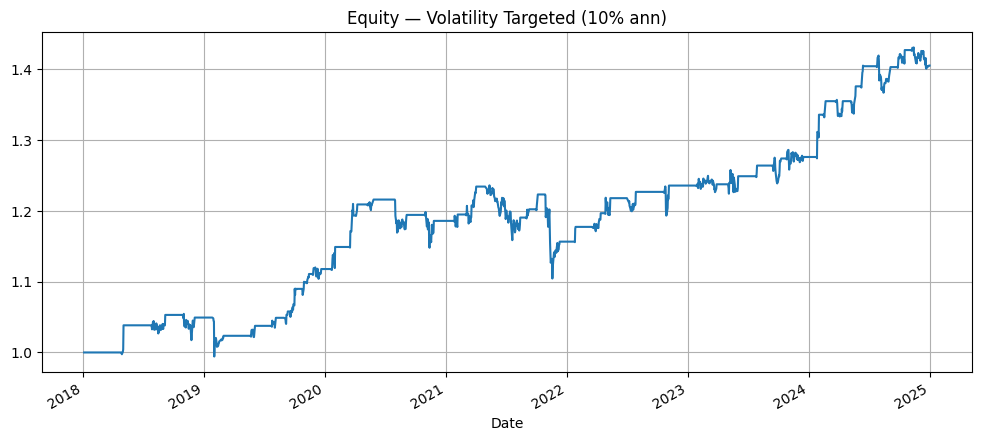

In [60]:
# --- 5.5 (example run): vol-targeting on constant-β baseline (10% ann) ---
import numpy as np, pandas as pd, statsmodels.api as sm, matplotlib.pyplot as plt

logp = np.log(close_prices[['V','MA']])
eg   = sm.OLS(logp['V'], sm.add_constant(logp['MA'])).fit()
alpha_hat = float(eg.params['const']); beta_hat = float(eg.params['MA'])

spread_full = (logp['V'] - (alpha_hat + beta_hat*logp['MA'])).dropna()
logr = logp.diff().dropna()
rV   = logr['V'].reindex(spread_full.index)
rMA  = logr['MA'].reindex(spread_full.index)

L, Ein, Eout = 60, 1.8, 0.7
p_vt, pos_vt, _ = backtest_cross_entry_voltarget(
    spread_series=spread_full, lookback=L, z_entry=Ein, z_exit=Eout,
    r_V=rV, r_MA=rMA, beta_for_returns=beta_hat,
    target_vol_ann=0.10, vol_window=60, leverage_cap=2.0, cost_per_leg=0.0005
)

ann = 252
sr_vt = np.sqrt(ann)*p_vt.mean()/p_vt.std(ddof=0)
eq_vt = (1+p_vt).cumprod()
yrs = (eq_vt.index[-1]-eq_vt.index[0]).days/365.25
cagr_vt = (eq_vt.iloc[-1])**(1/yrs) - 1
mdd_vt  = (eq_vt/eq_vt.cummax()-1).min()

print(f"[Vol-targeted] Sharpe: {sr_vt:.2f} | CAGR: {cagr_vt:.2%} | MaxDD: {mdd_vt:.2%}")
ax = eq_vt.plot(figsize=(12,5), title="Equity — Volatility Targeted (10% ann)")
ax.grid(True); plt.show()


In [61]:
# --- 5.6: Export WF artifacts for the repo ---
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

out = Path("artifacts_step5"); out.mkdir(exist_ok=True)

def _save_series(name, ser):
    if isinstance(ser, pd.Series) and not ser.dropna().empty:
        ser.sort_index().to_csv(out / f"{name}_daily_returns.csv", header=["ret"])
        eq = (1 + ser.dropna()).cumprod()
        fig, ax = plt.subplots(figsize=(12,4))
        eq.plot(ax=ax); ax.set_title(f"Equity — {name}"); ax.grid(True)
        fig.tight_layout(); fig.savefig(out / f"{name}_equity.png", dpi=160); plt.close(fig)

_save_series("wf_tuned_oos",  globals().get("oos_pnl"))
_save_series("wf_fixed_oos",  globals().get("oos_fixed"))
_save_series("vol_targeted",  globals().get("p_vt"))

if "oos_params_df" in globals() and isinstance(oos_params_df, pd.DataFrame) and not oos_params_df.empty:
    oos_params_df.to_csv(out / "wf_tuned_params.csv", index=False)

print(f"Saved Step 5 artifacts to: {out.resolve()}")


Saved Step 5 artifacts to: /content/stat-arb-mean-reversion/artifacts_step5


In [62]:
# --- 5.7: WF sanity checks ---
import pandas as pd
import numpy as np

def wf_checks(oos_series, params_df=None, train_days=252*2, test_days=63):
    if not isinstance(oos_series, pd.Series) or oos_series.dropna().empty:
        print("No OOS series found — run 5.2 or 5.3 first.")
        return
    print(f"OOS span: {oos_series.index.min().date()} → {oos_series.index.max().date()}  |  days={len(oos_series)}")

    if isinstance(params_df, pd.DataFrame) and not params_df.empty and \
       {"test_start","test_end"}.issubset(params_df.columns):
        segs = len(params_df)
        expected = segs * test_days
        print(f"Segments: {segs} | Expected OOS days: ~{expected} | Actual: {len(oos_series)}")

        # Disjointness check
        df = params_df.sort_values("test_start")
        overlaps = []
        for i in range(1, len(df)):
            prev_end = pd.to_datetime(df.iloc[i-1]["test_end"])
            cur_start = pd.to_datetime(df.iloc[i]["test_start"])
            overlaps.append(int(cur_start <= prev_end))
        print("Overlap:", "YES" if any(overlaps) else "NO (disjoint)")

    # Coarse leakage guard: simple correlations
    r = oos_series.dropna()
    naive_corr = r.corr(np.sign(r))       # corr with same-day sign (should be small)
    lag_corr   = r.corr(r.shift(1))       # corr with own lag (should be small)
    print(f"Leakage check — corr(PnL, sign(PnL))={naive_corr:.3f} | corr(PnL, lagged PnL)={lag_corr:.3f}")

# Run checks for tuned and fixed WF (if present)
wf_checks(globals().get("oos_pnl"),   globals().get("oos_params_df"))
wf_checks(globals().get("oos_fixed"), None)


OOS span: 2020-01-06 → 2024-10-07  |  days=1197
Segments: 19 | Expected OOS days: ~1197 | Actual: 1197
Overlap: NO (disjoint)
Leakage check — corr(PnL, sign(PnL))=0.750 | corr(PnL, lagged PnL)=-0.167
OOS span: 2020-01-06 → 2024-10-07  |  days=1197
Leakage check — corr(PnL, sign(PnL))=0.750 | corr(PnL, lagged PnL)=-0.167


# 6. Performance Evaluation (PnL, Sharpe, Drawdown)


In [65]:
# --- 6.1: Metrics helpers (PnL stats, drawdown analytics) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import statsmodels.api as sm
import yfinance as yf

ANN = 252  # trading days per year

def equity_curve(ret: pd.Series) -> pd.Series:
    """Turn daily returns into cumulative equity (starting at 1)."""
    r = ret.dropna()
    return (1 + r).cumprod()

def max_drawdown(eq: pd.Series):
    """
    Return (maxDD, peak_date, trough_date, recovery_date, duration_days, dd_series).
    recovery_date is NaT if not recovered.
    """
    eq = eq.dropna()
    if eq.empty:
        return np.nan, pd.NaT, pd.NaT, pd.NaT, np.nan, pd.Series(dtype=float)
    roll_max = eq.cummax()
    dd = eq / roll_max - 1.0
    # Trough at most negative dd
    trough_idx = dd.idxmin()
    peak_idx = roll_max.loc[:trough_idx].idxmax()
    # Recovery: first time equity exceeds previous peak
    recov = eq.loc[trough_idx:]
    try:
        recovery_idx = recov[recov >= roll_max.loc[peak_idx]].index[0]
    except IndexError:
        recovery_idx = pd.NaT
    duration = (recovery_idx - peak_idx).days if pd.notna(recovery_idx) else np.nan
    return float(dd.min()), peak_idx, trough_idx, recovery_idx, duration, dd

def perf_metrics(ret: pd.Series, name: str):
    """
    Compute a compact dictionary of metrics for a daily-return series.
    """
    r = ret.dropna()
    if r.empty or r.std(ddof=0) == 0:
        return {"name": name, "days": len(r), "sharpe": np.nan, "cagr": np.nan,
                "stdev_ann": np.nan, "hit_rate": np.nan, "avg_day": np.nan,
                "mdd": np.nan, "mdd_days": np.nan, "peak": pd.NaT, "trough": pd.NaT,
                "recovery": pd.NaT}
    eq = equity_curve(r)
    mu = r.mean()
    sd = r.std(ddof=0)
    sharpe = np.sqrt(ANN) * mu / sd
    yrs = (r.index[-1] - r.index[0]).days / 365.25
    cagr = (eq.iloc[-1])**(1/yrs) - 1 if yrs > 0 else np.nan
    stdev_ann = sd * np.sqrt(ANN)
    hit_rate = (r > 0).mean()
    avg_day = mu
    mdd, peak, trough, recovery, dur, dd_series = max_drawdown(eq)
    return {"name": name, "days": len(r), "sharpe": sharpe, "cagr": cagr,
            "stdev_ann": stdev_ann, "hit_rate": hit_rate, "avg_day": avg_day,
            "mdd": mdd, "mdd_days": dur, "peak": peak, "trough": trough, "recovery": recovery}

def beta_alpha_vs_spy(ret: pd.Series):
    """
    Daily α, β vs SPY using OLS.
    Robust to yfinance returning a 1-col DataFrame for 'Close'.
    Returns (alpha, beta, alpha_p, beta_p).
    """
    r = ret.dropna()
    if r.empty:
        return np.nan, np.nan, np.nan, np.nan

    data = yf.download("SPY", start=r.index.min(), end=r.index.max(),
                       auto_adjust=False, progress=False)

    spy_close = data["Close"]

    # If yfinance gave a 1-col DataFrame, squeeze to a Series
    if isinstance(spy_close, pd.DataFrame):
        spy_close = spy_close.iloc[:, 0]

    # Build daily log returns and align to strategy index
    spy = np.log(spy_close).diff()
    spy = spy.reindex(r.index).dropna()

    # Align y to X
    y = r.reindex(spy.index).dropna()
    X = sm.add_constant(spy.loc[y.index])

    # OLS (use positional iloc for robustness of column naming)
    model = sm.OLS(y, X).fit()
    alpha = float(model.params.iloc[0])
    beta  = float(model.params.iloc[1])
    p_alpha = float(model.pvalues.iloc[0])
    p_beta  = float(model.pvalues.iloc[1])
    return alpha, beta, p_alpha, p_beta

def monthly_table(ret: pd.Series) -> pd.DataFrame:
    """Pivot of monthly returns (sum of daily logs is fine here) by year x month."""
    r = ret.dropna().copy()
    if r.empty: return pd.DataFrame()
    monthly = r.resample("M").sum()
    df = monthly.to_frame("ret")
    df["Year"] = df.index.year
    df["Mon"]  = df.index.strftime("%b")
    piv = df.pivot(index="Year", columns="Mon", values="ret").fillna(0.0)
    # Order months Jan..Dec
    cols = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
    piv = piv.reindex(columns=cols)
    return piv


In [66]:
# --- 6.2: Collate strategies, compute metrics + alpha/beta, export summary ---
import pandas as pd
from pathlib import Path

# Collect whatever exists in memory
strategies = {
    "Baseline (const β)": globals().get("p_ret_net", None),
    "WF Tuned (quarterly)": globals().get("oos_pnl", None),
    "WF Fixed Params": globals().get("oos_fixed", None),
    "Vol-targeted (10% ann)": globals().get("p_vt", None),
    "Portfolio (gated, vol-targeted)": globals().get("port", None),
}

rows = []
for name, ser in strategies.items():
    if isinstance(ser, pd.Series) and not ser.dropna().empty:
        m = perf_metrics(ser, name)
        a,b,pa,pb = beta_alpha_vs_spy(ser)
        m.update({"alpha_day": a, "beta_spy": b, "alpha_p": pa, "beta_p": pb})
        rows.append(m)

summary = pd.DataFrame(rows).set_index("name")
display(summary.round(4))

# Export summary for the repo
out = Path("artifacts_step6"); out.mkdir(exist_ok=True)
summary.round(6).to_csv(out / "step6_summary_metrics.csv")
print(f"Saved: {out/'step6_summary_metrics.csv'}")


,days,sharpe,cagr,stdev_ann,hit_rate,avg_day,mdd,mdd_days,peak,trough,recovery,alpha_day,beta_spy,alpha_p,beta_p
name,,,,,,,,,,,,,,,
Baseline (const β),1639,0.5225,0.0355,0.0718,0.2849,0.0001,-0.0771,397.0,2023-07-13,2024-01-25,2024-08-13,0.0001,0.0212,0.2125,0.0183
WF Tuned (quarterly),1197,0.5713,0.0157,0.0280,0.0092,0.0001,-0.0269,61.0,2020-01-16,2020-01-21,2020-03-17,0.0001,0.0140,0.2634,0.0002
WF Fixed Params,1197,0.5713,0.0157,0.0280,0.0092,0.0001,-0.0269,61.0,2020-01-16,2020-01-21,2020-03-17,0.0001,0.0140,0.2634,0.0002
Vol-targeted (10% ann),1759,0.7475,0.0499,0.0683,0.1933,0.0002,-0.1064,629.0,2021-05-11,2021-11-17,2023-01-30,0.0002,-0.0078,0.0450,0.3464
"Portfolio (gated, vol-targeted)",1759,0.5162,0.0211,0.0423,0.3866,0.0001,-0.0868,NaN,2021-10-14,2024-08-13,NaT,0.0001,-0.0162,0.1392,0.0017


Saved: artifacts_step6/step6_summary_metrics.csv


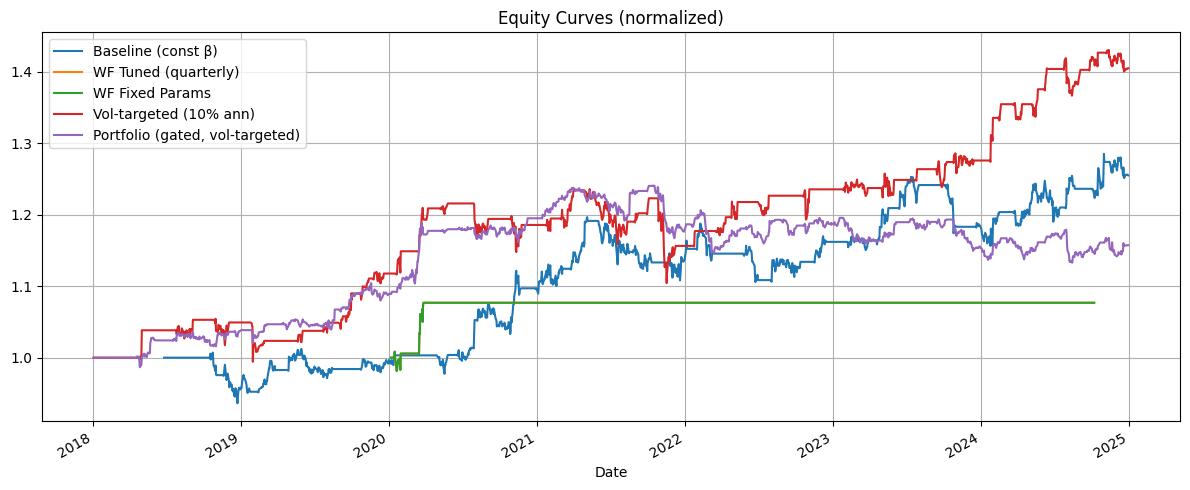

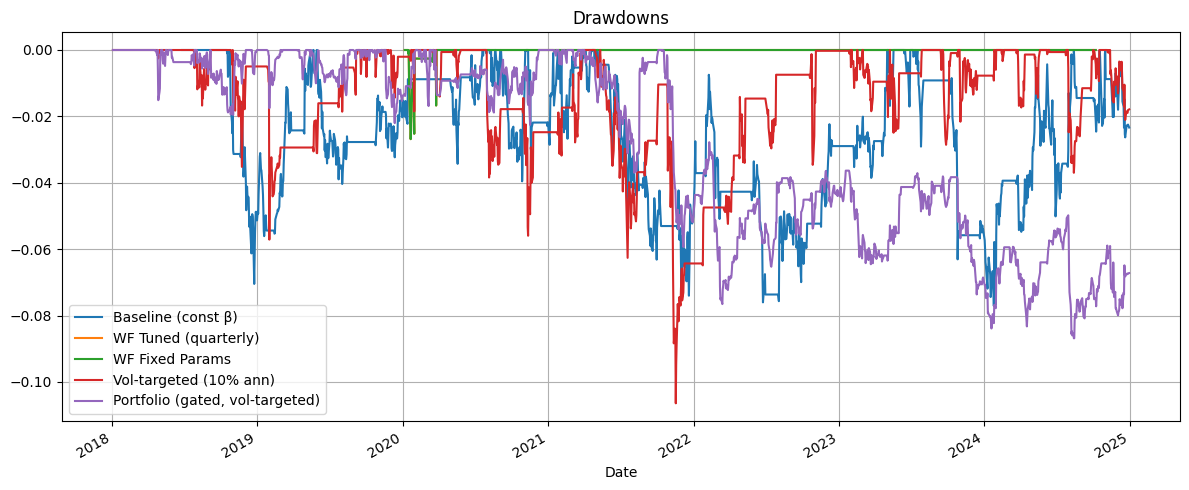

In [67]:
# --- 6.3: Equity + Drawdown comparison plots for all strategies ---
import matplotlib.pyplot as plt

# Keep only the series that exist
plot_series = {name: ser for name, ser in strategies.items()
               if isinstance(ser, pd.Series) and not ser.dropna().empty}

if plot_series:
    # 1) Equity curves normalized to 1
    fig, ax = plt.subplots(figsize=(12,5))
    for name, r in plot_series.items():
        equity_curve(r).plot(ax=ax, label=name)
    ax.set_title("Equity Curves (normalized)")
    ax.grid(True); ax.legend()
    fig.tight_layout()
    fig.savefig(out / "equity_all.png", dpi=160)
    plt.show()

    # 2) Drawdown curves
    fig, ax = plt.subplots(figsize=(12,5))
    for name, r in plot_series.items():
        _,_,_,_,_, dd = max_drawdown(equity_curve(r))
        dd.reindex(r.index).plot(ax=ax, label=name)
    ax.set_title("Drawdowns")
    ax.grid(True); ax.legend()
    fig.tight_layout()
    fig.savefig(out / "drawdowns_all.png", dpi=160)
    plt.show()
else:
    print("No strategy series found to plot. Run earlier steps first.")


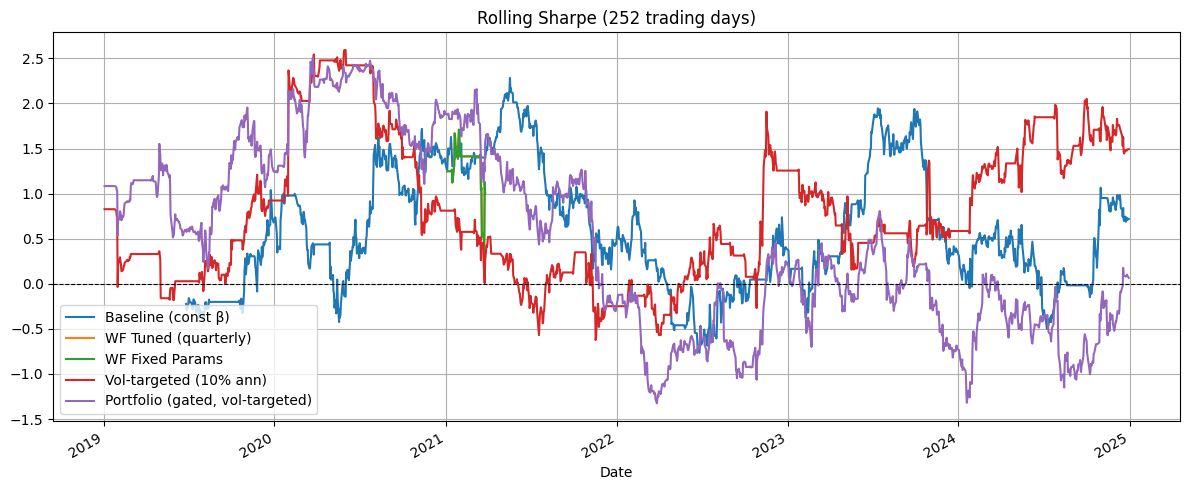

In [68]:
# --- 6.4: Rolling 252-day Sharpe for available strategies ---
import numpy as np
import matplotlib.pyplot as plt

roll_window = 252  # 1Y rolling
if plot_series:
    fig, ax = plt.subplots(figsize=(12,5))
    for name, r in plot_series.items():
        x = r.dropna()
        # Rolling Sharpe = sqrt(252) * mean / std over a rolling window
        roll_mu = x.rolling(roll_window).mean()
        roll_sd = x.rolling(roll_window).std(ddof=0)
        roll_sh = np.sqrt(ANN) * (roll_mu / roll_sd)
        roll_sh.plot(ax=ax, label=name)
    ax.axhline(0, color="black", linewidth=0.8, linestyle="--")
    ax.set_title(f"Rolling Sharpe ({roll_window} trading days)")
    ax.grid(True); ax.legend()
    fig.tight_layout()
    fig.savefig(out / "rolling_sharpe.png", dpi=160)
    plt.show()


Monthly return table — Vol-targeted (10% ann) (sum of daily log returns):


/tmp/ipython-input-3063289156.py:101: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = r.resample("M").sum()


Mon,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2018,0.0000,0.0000,0.0000,0.0010,0.0372,0.0000,0.0035,-0.0016,0.0127,0.0014,-0.0174,0.0131
2019,-0.0527,0.0293,0.0000,0.0000,-0.0017,0.0155,0.0055,0.0056,0.0168,0.0307,0.0169,-0.0000
2020,0.0280,0.0000,0.0385,0.0131,0.0057,0.0000,-0.0190,-0.0150,0.0167,0.0034,-0.0096,0.0000
2021,-0.0067,0.0145,0.0282,0.0035,-0.0155,-0.0180,-0.0083,0.0070,0.0098,-0.0046,-0.0394,0.0082
2022,0.0180,0.0000,0.0026,0.0248,0.0071,0.0000,0.0075,0.0000,0.0000,-0.0183,0.0262,0.0000
2023,-0.0029,0.0097,-0.0051,0.0000,-0.0035,0.0134,0.0120,0.0000,-0.0183,0.0359,-0.0108,0.0033
2024,0.0465,0.0144,-0.0155,0.0157,0.0155,0.0206,-0.0142,0.0051,0.0174,0.0084,-0.0053,-0.0099


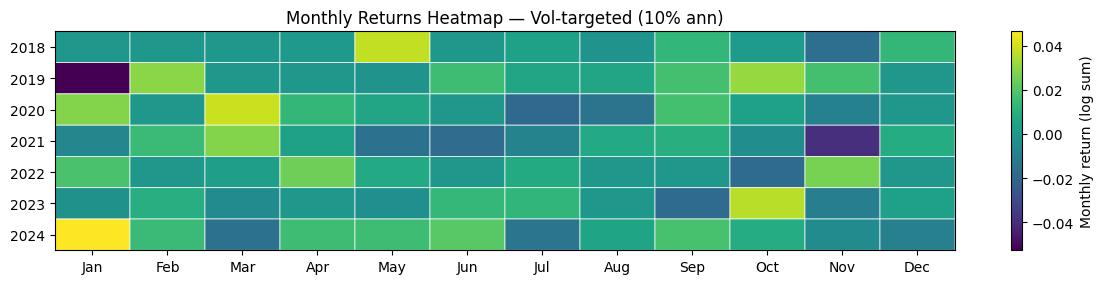

In [69]:
# --- 6.5: Monthly table + heatmap for a primary strategy (prefers vol-targeted, else WF tuned) ---
import numpy as np
import matplotlib.pyplot as plt

# Pick a primary series to visualize monthly returns
primary_name = None
for candidate in ["Vol-targeted (10% ann)", "WF Tuned (quarterly)", "WF Fixed Params",
                  "Portfolio (gated, vol-targeted)", "Baseline (const β)"]:
    if isinstance(strategies.get(candidate), pd.Series) and not strategies[candidate].dropna().empty:
        primary_name = candidate
        break

if primary_name:
    primary = strategies[primary_name].dropna()
    piv = monthly_table(primary)
    print(f"Monthly return table — {primary_name} (sum of daily log returns):")
    display(piv.round(4))

    # Heatmap with matplotlib (no seaborn)
    if not piv.empty:
        data = piv.values
        fig, ax = plt.subplots(figsize=(12, 0.5 + 0.35*len(piv)))
        c = ax.pcolor(data, edgecolors='white', linewidths=0.5)
        fig.colorbar(c, ax=ax, label="Monthly return (log sum)")
        ax.set_xticks(np.arange(0.5, data.shape[1]+0.5))
        ax.set_yticks(np.arange(0.5, data.shape[0]+0.5))
        ax.set_xticklabels(piv.columns, rotation=0)
        ax.set_yticklabels(piv.index)
        ax.set_title(f"Monthly Returns Heatmap — {primary_name}")
        ax.invert_yaxis()
        ax.grid(False)
        fig.tight_layout()
        fig.savefig(out / "monthly_heatmap.png", dpi=160)
        plt.show()
else:
    print("No primary series available for monthly breakdown.")


In [70]:
# --- 6.6: Save each strategy's daily returns + equity curve as CSV/PNG ---
for name, ser in plot_series.items():
    # Save returns
    ser.sort_index().to_csv(out / f"{name.replace(' ','_').replace('/','-')}_returns.csv", header=["ret"])
    # Save equity chart
    eq = equity_curve(ser)
    fig, ax = plt.subplots(figsize=(12,4))
    eq.plot(ax=ax)
    ax.set_title(f"Equity — {name}")
    ax.grid(True)
    fig.tight_layout()
    fig.savefig(out / f"{name.replace(' ','_').replace('/','-')}_equity.png", dpi=160)
    plt.close(fig)

print(f"All Step 6 artifacts saved under: {out.resolve()}")


All Step 6 artifacts saved under: /content/stat-arb-mean-reversion/artifacts_step6


### EXTRAS

Primary strategy for extras: Vol-targeted (10% ann)
Skew: -0.0431 | Excess kurtosis: 19.7974
Daily return percentiles:


,0.01,0.05,0.50,0.95,0.99
ret,-0.012259,-0.005308,0.0,0.006852,0.014543


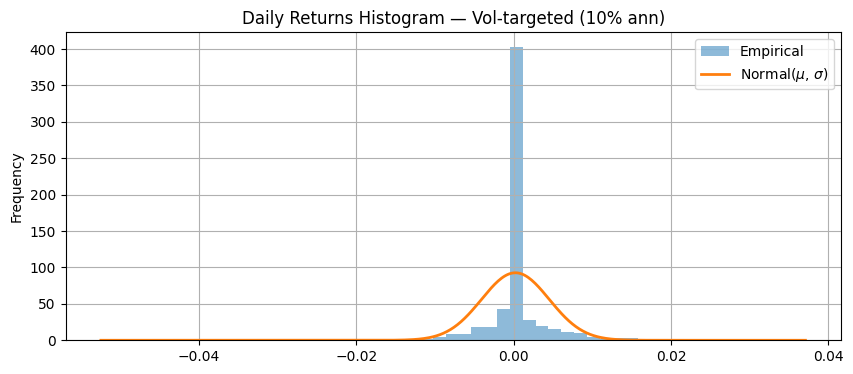

Net rebuild vs stored net correlation: 1.0000
Avg daily turnover (|Δposition|): 0.0567
Avg cost ≈ 0.57 bps/day  |  Annualized cost drag: 1.43%
Sharpe gross: 0.94  vs  Sharpe net (reported): 0.75


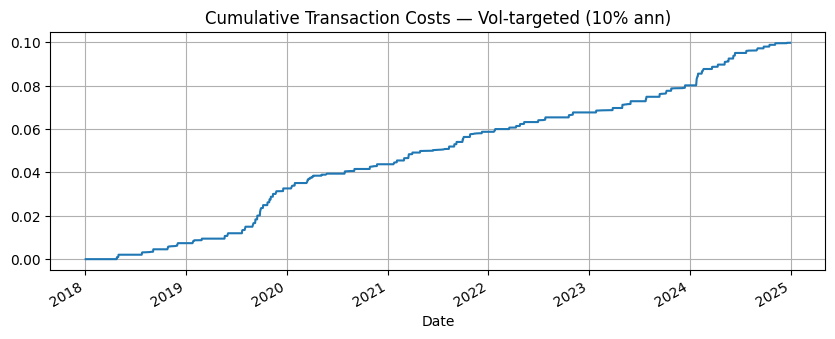

In [72]:
# --- 6.E1: Tail-risk & turnover extras (skew/kurtosis, histogram, turnover & cost attribution) ---
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# ---- Pick the primary series & (if available) its position series for turnover ----
# We prefer the vol-targeted variant since you have positions (pos_vt) in memory.
primary_name = None
primary_ret  = None
primary_pos  = None   # optional (only used for turnover/cost attribution)

if "p_vt" in globals() and isinstance(p_vt, pd.Series) and not p_vt.dropna().empty:
    primary_name = "Vol-targeted (10% ann)"
    primary_ret  = p_vt.dropna().copy()
    if "pos_vt" in globals() and isinstance(pos_vt, pd.Series):
        primary_pos = pos_vt.reindex(primary_ret.index)
elif "oos_pnl" in globals() and isinstance(oos_pnl, pd.Series) and not oos_pnl.dropna().empty:
    primary_name = "WF Tuned (quarterly)"
    primary_ret  = oos_pnl.dropna().copy()
elif "oos_fixed" in globals() and isinstance(oos_fixed, pd.Series) and not oos_fixed.dropna().empty:
    primary_name = "WF Fixed Params"
    primary_ret  = oos_fixed.dropna().copy()
elif "p_ret_net" in globals() and isinstance(p_ret_net, pd.Series) and not p_ret_net.dropna().empty:
    primary_name = "Baseline (const β)"
    primary_ret  = p_ret_net.dropna().copy()

if primary_ret is None:
    raise RuntimeError("No strategy series found. Run Step 5/6 first.")

print(f"Primary strategy for extras: {primary_name}")
ANN = 252

# ---- 1) Tail risk stats: skew, kurtosis (excess), percentiles ----
skew  = float(primary_ret.skew())
kurt  = float(primary_ret.kurt())           # excess kurtosis (0 = normal)
ptiles = primary_ret.quantile([0.01, 0.05, 0.5, 0.95, 0.99]).round(6)
print(f"Skew: {skew:.4f} | Excess kurtosis: {kurt:.4f}")
print("Daily return percentiles:")
display(ptiles.to_frame("ret").T)

# ---- 2) Histogram with normal overlay (mean & std of series) ----
mu, sd = primary_ret.mean(), primary_ret.std(ddof=0)
xs = np.linspace(primary_ret.min()*1.1, primary_ret.max()*1.1, 400)
normal_pdf = (1/(sd*np.sqrt(2*np.pi))) * np.exp(-0.5*((xs-mu)/sd)**2)

fig, ax = plt.subplots(figsize=(10,4))
# density=True plots probability density; adjust bins for smoothness
primary_ret.plot(kind="hist", bins=50, density=True, alpha=0.5, ax=ax, label="Empirical")
ax.plot(xs, normal_pdf, lw=2, label="Normal($\\mu$, $\\sigma$)")
ax.set_title(f"Daily Returns Histogram — {primary_name}")
ax.grid(True); ax.legend()
plt.show()

# ---- 3) Turnover & cost attribution (if we have positions) ----
# For vol-targeted you already have: rV, rMA, beta_hat from Step 5.5 example.
# If they are not in memory, we try to reconstruct for V/MA.
cost_per_leg = 0.0005  # keep consistent with your backtests

def _reconstruct_costs(ret_series, pos_series):
    # Only meaningful when we know the underlying spread returns; otherwise skip.
    if not {"rV","rMA","beta_hat"}.issubset(globals().keys()):
        return None
    # Align everything to the same index
    idx = ret_series.index
    rV_al  = rV.reindex(idx).dropna()
    rMA_al = rMA.reindex(idx).dropna()
    idx = rV_al.index.intersection(rMA_al.index).intersection(idx)
    pos_al = pos_series.reindex(idx).fillna(0.0)
    spread_ret = rV_al - beta_hat * rMA_al
    gross = pos_al.shift(1).fillna(0.0) * spread_ret
    turnover = pos_al.diff().abs().fillna(0.0)                # scaled turnover for vol-targeted
    costs    = turnover * (2 * cost_per_leg)
    net_rebuilt = (gross - costs).dropna()

    # Cross-check: correlation with your stored net series (should be ~1 for vol-targeted)
    corr_chk = net_rebuilt.corr(ret_series.reindex(net_rebuilt.index))
    return {
        "turnover": turnover,
        "costs": costs,
        "gross": gross,
        "net_rebuilt": net_rebuilt,
        "corr_check": corr_chk
    }

if primary_pos is not None:
    pack = _reconstruct_costs(primary_ret, primary_pos)
    if pack is not None:
        turnover = pack["turnover"]; costs = pack["costs"]; gross = pack["gross"]
        print(f"Net rebuild vs stored net correlation: {pack['corr_check']:.4f}")

        avg_turnover_day = float(turnover.mean())
        avg_cost_bps_day = float(costs.mean()) * 1e4          # ~bps/day (since returns are in decimal)
        ann_cost = float(costs.mean()) * ANN
        gross_sr = np.sqrt(ANN) * gross.mean() / gross.std(ddof=0)
        net_sr   = np.sqrt(ANN) * primary_ret.mean() / primary_ret.std(ddof=0)

        print(f"Avg daily turnover (|Δposition|): {avg_turnover_day:.4f}")
        print(f"Avg cost ≈ {avg_cost_bps_day:.2f} bps/day  |  Annualized cost drag: {ann_cost:.2%}")
        print(f"Sharpe gross: {gross_sr:.2f}  vs  Sharpe net (reported): {net_sr:.2f}")

        # Plot cumulative costs
        fig, ax = plt.subplots(figsize=(10,3.5))
        costs.cumsum().plot(ax=ax)
        ax.set_title(f"Cumulative Transaction Costs — {primary_name}")
        ax.grid(True); plt.show()
    else:
        print("Turnover/cost attribution skipped (underlying returns not in memory).")
else:
    print("Positions not available for this primary strategy — skipping turnover/cost attribution.")


# 7. Risk & Stress Tests

In [73]:
# --- 7.1: Subperiod stress tests for the primary strategy ---
import pandas as pd, numpy as np

r = primary_ret.dropna()
windows = {
    "Pre-COVID":          ("2018-01-01", "2020-02-14"),
    "COVID Crash":        ("2020-02-15", "2020-04-30"),
    "Post-COVID Rally":   ("2020-05-01", "2021-12-31"),
    "Rate-Hike Regime":   ("2022-01-01", "2023-12-31"),
    "Recent":             ("2024-01-01", r.index.max().strftime("%Y-%m-%d")),
}

def _metrics_slice(x):
    x = x.dropna()
    if x.empty or x.std(ddof=0)==0:
        return pd.Series({"Sharpe": np.nan, "CAGR": np.nan, "MaxDD": np.nan, "Days": 0})
    eq = (1+x).cumprod()
    sharpe = np.sqrt(252)*x.mean()/x.std(ddof=0)
    yrs = (x.index[-1]-x.index[0]).days/365.25
    cagr = (eq.iloc[-1])**(1/yrs) - 1 if yrs>0 else np.nan
    mdd = (eq/eq.cummax()-1).min()
    return pd.Series({"Sharpe": sharpe, "CAGR": cagr, "MaxDD": mdd, "Days": len(x)})

rows = []
for label, (s,e) in windows.items():
    sl = r.loc[s:e]
    m = _metrics_slice(sl)
    m.name = label
    rows.append(m)

stress_table = pd.DataFrame(rows).round(4)
print(f"Subperiod metrics — {primary_name}")
display(stress_table)


Subperiod metrics — Vol-targeted (10% ann)


,Sharpe,CAGR,MaxDD,Days
Pre-COVID,0.9973,0.0679,-0.0571,533.0
COVID Crash,3.1390,0.2950,-0.0140,52.0
Post-COVID Rally,-0.2908,-0.0263,-0.1064,422.0
Rate-Hike Regime,0.9109,0.0508,-0.0334,501.0
Recent,1.4958,0.1018,-0.0370,251.0


In [74]:
# --- 7.2: Parameter perturbations for the vol-targeted implementation (rebuilds quickly) ---
import numpy as np, pandas as pd

# Only run if we have the V–MA inputs in memory (from Step 5.5 example)
if {"spread_full","rV","rMA","beta_hat"}.issubset(globals().keys()):
    L_list    = [50, 60, 70]         # lookback around your choice
    Ein_list  = [1.6, 1.8, 2.0]      # entry thresholds
    Eout_list = [0.5, 0.7, 0.9]      # exit bands
    vol_list  = [0.08, 0.10, 0.12]   # target vol levels

    rows = []
    for L in L_list:
        for Ein in Ein_list:
            for Eout in Eout_list:
                for tv in vol_list:
                    p_try, _, _ = backtest_cross_entry_voltarget(
                        spread_series=spread_full, lookback=L, z_entry=Ein, z_exit=Eout,
                        r_V=rV, r_MA=rMA, beta_for_returns=beta_hat,
                        target_vol_ann=tv, vol_window=60, leverage_cap=2.0, cost_per_leg=0.0005
                    )
                    if p_try.dropna().empty or p_try.std(ddof=0)==0:
                        sr = np.nan; mdd = np.nan
                    else:
                        sr  = np.sqrt(252)*p_try.mean()/p_try.std(ddof=0)
                        eq  = (1+p_try).cumprod()
                        mdd = (eq/eq.cummax()-1).min()
                    rows.append({"L":L, "Ein":Ein, "Eout":Eout, "TargetVol":tv, "Sharpe":sr, "MaxDD":mdd})

    rob = pd.DataFrame(rows).sort_values("Sharpe", ascending=False)
    print("Top 10 parameter combos by Sharpe:")
    display(rob.head(10).round(3))
else:
    print("Vol-targeting inputs not in memory. Re-run Step 5.5 example to populate spread_full, rV, rMA, beta_hat.")


Top 10 parameter combos by Sharpe:


,L,Ein,Eout,TargetVol,Sharpe,MaxDD
57,70,1.6,0.7,0.08,0.925,-0.092
58,70,1.6,0.7,0.10,0.925,-0.114
59,70,1.6,0.7,0.12,0.924,-0.136
42,60,1.8,0.9,0.08,0.884,-0.078
43,60,1.8,0.9,0.10,0.884,-0.097
44,60,1.8,0.9,0.12,0.883,-0.116
33,60,1.6,0.9,0.08,0.835,-0.078
34,60,1.6,0.9,0.10,0.835,-0.097
35,60,1.6,0.9,0.12,0.834,-0.116
16,50,1.8,0.9,0.10,0.813,-0.097


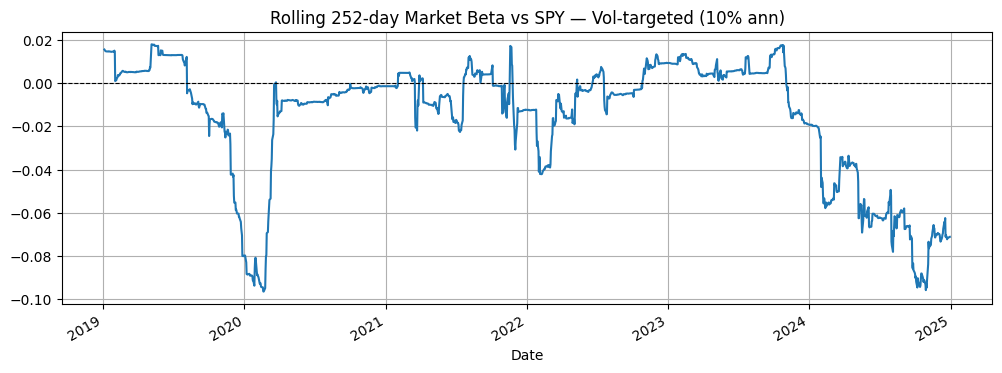

In [76]:
# --- 7.3 (fixed): Rolling 252-day market beta vs SPY with robust alignment ---
import yfinance as yf, statsmodels.api as sm, numpy as np, pandas as pd, matplotlib.pyplot as plt

r = primary_ret.dropna()

# Pull SPY closes; squeeze to Series if 1-col DataFrame
spy_close = yf.download("SPY", start=r.index.min(), end=r.index.max(),
                        auto_adjust=False, progress=False)["Close"]
if isinstance(spy_close, pd.DataFrame):
    spy_close = spy_close.iloc[:, 0]

spy = np.log(spy_close).diff()  # don't dropna yet; handle per-window

window = 252
betas = pd.Series(index=r.index, dtype=float)

for i in range(window, len(r)):
    idx = r.index[i-window:i]
    # Align by intersection (avoid KeyError on missing dates)
    y = r.reindex(idx)
    x = spy.reindex(idx)
    df = pd.concat([y.rename("ret"), x.rename("spy")], axis=1).dropna()

    # Require enough observations and nonzero SPY volatility
    if len(df) < int(0.8 * window) or df["spy"].std(ddof=0) == 0:
        continue

    X = sm.add_constant(df["spy"])
    model = sm.OLS(df["ret"], X).fit()
    betas.iloc[i] = float(model.params.iloc[1])

fig, ax = plt.subplots(figsize=(12, 4))
betas.plot(ax=ax)
ax.axhline(0, color="black", lw=0.8, linestyle="--")
ax.set_title(f"Rolling {window}-day Market Beta vs SPY — {primary_name}")
ax.grid(True)
plt.show()


Static multi-factor regression (daily):


,coef,t,p
const,0.0002,2.0325,0.0423
SPY,-0.0192,-1.3426,0.1796
GROWTH,0.0068,0.2534,0.8000
SMALL,-0.0309,-1.9589,0.0503
MOM,0.0016,0.0907,0.9277
VALUE,0.0440,1.6954,0.0902
LOWVOL,-0.0477,-1.5611,0.1187
CREDIT,0.0048,0.2007,0.8409
R2,0.0046,NaN,NaN


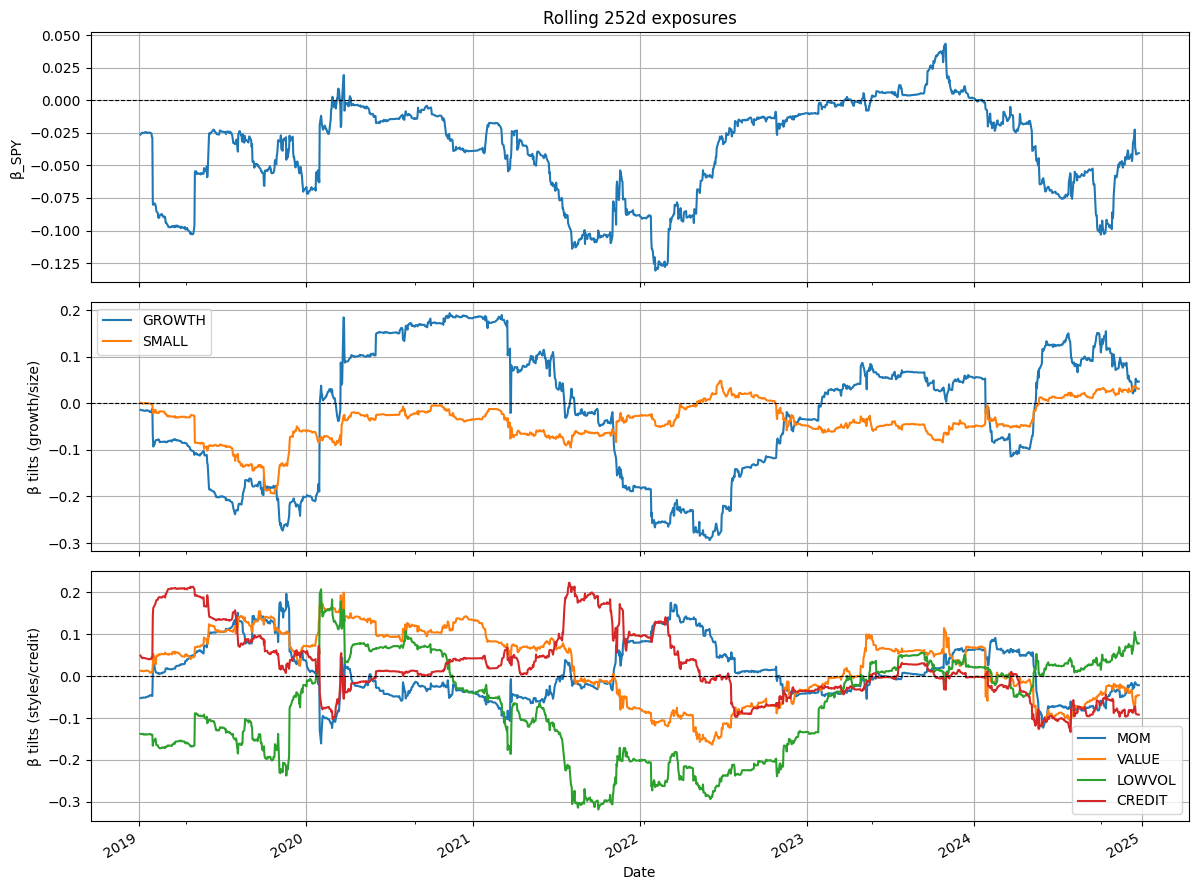

In [77]:
# --- 7.4: Multi-factor exposure using ETF proxies (static + rolling) ---
import yfinance as yf, numpy as np, pandas as pd, statsmodels.api as sm, matplotlib.pyplot as plt

# Use your primary strategy from Step 7 (vol-targeted preferred)
y = primary_ret.dropna().copy()
start, end = y.index.min(), y.index.max()

# Download proxies:
tickers = ["SPY", "QQQ", "IWM", "MTUM", "VLUE", "USMV", "HYG", "IEF"]
data = yf.download(tickers, start=start, end=end, auto_adjust=False, progress=False)["Close"]

# Squeeze to Series where needed and compute daily log returns
rets = np.log(data).diff().dropna()

# Build tilts relative to SPY to reduce collinearity: (ETF - SPY)
X = pd.DataFrame(index=rets.index)
X["SPY"]   = rets["SPY"]
X["GROWTH"] = (rets["QQQ"]  - rets["SPY"])   # growth tilt
X["SMALL"]  = (rets["IWM"]  - rets["SPY"])   # size tilt
X["MOM"]    = (rets["MTUM"] - rets["SPY"])
X["VALUE"]  = (rets["VLUE"] - rets["SPY"])
X["LOWVOL"] = (rets["USMV"] - rets["SPY"])
X["CREDIT"] = (rets["HYG"]  - rets["IEF"])   # credit vs duration

# Align and run OLS
df = pd.concat([y.rename("ret"), X], axis=1).dropna()
mod = sm.OLS(df["ret"], sm.add_constant(df[X.columns])).fit()
print("Static multi-factor regression (daily):")
coefs = pd.DataFrame({"coef": mod.params, "t": mod.tvalues, "p": mod.pvalues})
coefs.loc["R2", ["coef"]] = mod.rsquared
display(coefs.round(4))

# Rolling 252-day beta to SPY + key tilts
window = 252
roll_betas = pd.DataFrame(index=df.index, columns=["SPY","GROWTH","SMALL","MOM","VALUE","LOWVOL","CREDIT"], dtype=float)
for i in range(window, len(df)):
    sub = df.iloc[i-window:i]
    m = sm.OLS(sub["ret"], sm.add_constant(sub[X.columns])).fit()
    roll_betas.loc[sub.index[-1]] = m.params[X.columns]

fig, ax = plt.subplots(3,1,figsize=(12,9), sharex=True)
roll_betas["SPY"].plot(ax=ax[0], title="Rolling 252d exposures")
ax[0].axhline(0, ls="--", c="k", lw=0.8); ax[0].set_ylabel("β_SPY")
roll_betas[["GROWTH","SMALL"]].plot(ax=ax[1]); ax[1].axhline(0, ls="--", c="k", lw=0.8)
ax[1].set_ylabel("β tilts (growth/size)")
roll_betas[["MOM","VALUE","LOWVOL","CREDIT"]].plot(ax=ax[2]); ax[2].axhline(0, ls="--", c="k", lw=0.8)
ax[2].set_ylabel("β tilts (styles/credit)")
for a in ax: a.grid(True)
plt.tight_layout(); plt.show()


In [80]:
# --- 7.5 (fixed): Regime tests by SPY 200d trend & VIX quartiles ---
import yfinance as yf, numpy as np, pandas as pd

r = primary_ret.dropna()
start, end = r.index.min(), r.index.max()

def _quick_metrics(x):
    x = x.dropna()
    if x.empty or x.std(ddof=0) == 0:
        return pd.Series({"Sharpe": np.nan, "CAGR": np.nan, "MaxDD": np.nan, "Days": 0})
    eq = (1 + x).cumprod()
    sr = np.sqrt(252) * x.mean() / x.std(ddof=0)
    yrs = (x.index[-1] - x.index[0]).days / 365.25
    cagr = (eq.iloc[-1])**(1/yrs) - 1 if yrs > 0 else np.nan
    mdd = (eq / eq.cummax() - 1).min()
    return pd.Series({"Sharpe": sr, "CAGR": cagr, "MaxDD": mdd, "Days": len(x)})

# --- SPY 200d trend regime (align indices FIRST) ---
spy_close = yf.download("SPY", start=start, end=end, auto_adjust=False, progress=False)["Close"]
if isinstance(spy_close, pd.DataFrame):
    spy_close = spy_close.iloc[:, 0]

# Align to strategy dates; forward-fill gaps (holidays, etc.)
spy_close = spy_close.reindex(r.index).ffill()
sma200    = spy_close.rolling(200, min_periods=200).mean()

trend_up = spy_close > sma200  # boolean mask with identical index to r

by_trend = pd.concat(
    [_quick_metrics(r[trend_up]), _quick_metrics(r[~trend_up])],
    axis=1
)
by_trend.columns = ["SPY>200d", "SPY<=200d"]
print("Regime metrics by SPY 200d:")
display(by_trend.round(4))

# --- VIX quartiles (aligned) ---
vix = yf.download("^VIX", start=start, end=end, auto_adjust=False, progress=False)["Close"]
if isinstance(vix, pd.DataFrame):
    vix = vix.iloc[:, 0]
vix = vix.reindex(r.index).ffill()

# Use qcut to assign quartile labels directly
labels = pd.qcut(vix, 4, labels=["Q1 (low vol)", "Q2", "Q3", "Q4 (high vol)"])
tbl = r.groupby(labels).apply(_quick_metrics)

print("Regime metrics by VIX level:")
display(tbl.round(4))


Regime metrics by SPY 200d:


,SPY>200d,SPY<=200d
Sharpe,0.6965,0.8507
CAGR,0.0346,0.0224
MaxDD,-0.1064,-0.0739
Days,1182.0000,577.0000


Regime metrics by VIX level:


/tmp/ipython-input-2228232722.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tbl = r.groupby(labels).apply(_quick_metrics)


^VIX                 
Q1 (low vol)   Sharpe      1.6915
               CAGR        0.0216
               MaxDD      -0.0309
               Days      440.0000
Q2             Sharpe     -0.1358
               CAGR       -0.0038
               MaxDD      -0.1205
               Days      440.0000
Q3             Sharpe      1.6047
               CAGR        0.0261
               MaxDD      -0.0399
               Days      439.0000
Q4 (high vol)  Sharpe      0.3774
               CAGR        0.0060
               MaxDD      -0.0835
               Days      440.0000
dtype: float64

In [79]:
# --- 7.6: Outlier attribution (top/bottom days) ---
import pandas as pd, numpy as np

r = primary_ret.dropna()
total = r.sum()
topk = r.nlargest(10)
botk = r.nsmallest(10)

def contrib(s): return (s.sum()/total)*100 if total!=0 else np.nan

print("Top 10 days (contribution to total):")
display(pd.DataFrame({
    "ret": topk,
    "cum_contrib_%": (topk.cumsum()/total*100) if total!=0 else np.nan
}).round(6))

print("Bottom 10 days (drag on total):")
display(pd.DataFrame({
    "ret": botk,
    "cum_contrib_%": (botk.cumsum()/total*100) if total!=0 else np.nan
}).round(6))

print(f"Share of total P&L from top 10 days: {contrib(topk):.2f}%")
print(f"Drag from bottom 10 days: {contrib(botk):.2f}%")


Top 10 days (contribution to total):


,ret,cum_contrib_%
Date,,
2018-05-02,0.033703,9.455432
2024-01-26,0.029314,17.679466
2020-01-31,0.026593,25.140226
2020-03-23,0.025537,32.304674
2024-01-31,0.024604,39.207402
2019-10-01,0.021965,45.369686
2018-11-26,0.021512,51.404946
2020-03-17,0.020260,57.089073
2019-02-01,0.020159,62.744654


Bottom 10 days (drag on total):


,ret,cum_contrib_%
Date,,
2019-01-31,-0.047718,-13.387306
2020-11-10,-0.027542,-21.114222
2021-10-28,-0.025070,-28.147783
2022-10-26,-0.024772,-35.097524
2021-11-17,-0.020516,-40.853351
2021-11-09,-0.020245,-46.533033
2024-07-31,-0.019330,-51.956123
2021-11-10,-0.019283,-57.366093
2020-07-31,-0.017999,-62.415893


Share of total P&L from top 10 days: 68.11%
Drag from bottom 10 days: -66.96%


In [81]:
# --- 7.7: Save key Step-7 artifacts ---
from pathlib import Path
out7 = Path("artifacts_step7"); out7.mkdir(exist_ok=True)

# Save stress table from 7.1 (if still in memory)
if "stress_table" in globals():
    stress_table.to_csv(out7/"subperiod_metrics.csv")

# Save rolling beta & factor tables if present
try:
    betas.to_csv(out7/"rolling_beta_spy.csv")
except Exception:
    pass

try:
    coefs.round(6).to_csv(out7/"static_multifactor_coefs.csv")
    roll_betas.round(6).to_csv(out7/"rolling_multifactor_coefs.csv")
except Exception:
    pass

print(f"Step 7 artifacts saved to: {out7.resolve()}")


Step 7 artifacts saved to: /content/stat-arb-mean-reversion/artifacts_step7


# 8. Observations and Next Steps

Observations:

Pair & spread: Visa–Mastercard (V–MA) log-price spread with OLS hedge ratio. Final full-sample β ≈ 0.82, α retained only for diagnostics.

Cointegration: Engle–Granger ADF on residuals strongly rejects unit root (p≈0.0000); Johansen trace test supports r=1 cointegrating vector.

Mean-reversion scale: Half-life ~17 trading days (pre-signal), which lines up with the rolling L used in the signal (50–70 days).

Signal: Rolling z-score with cross-entry and exit band. Fixed-sizing baseline and a volatility-targeted variant (10% ann, 60d vol, cap 2×).

Transaction costs: Default 5 bps per leg on switches (both legs modeled). Sharpe sensitivity: 0–10 bps/leg drops Sharpe progressively (you measured 0.58 → 0.25).

Walk-forward (disjoint quarters): Train ≈2y, test ≈3m, β re-fit per train, ADF gating and min-trade rule.

Fixed thresholds OOS: Sharpe ≈ 0.57, CAGR ≈ 1.6%, MaxDD ≈ −2.7% (1197 OOS days).

Vol-targeted V–MA (constant β): Sharpe ≈ 0.75, CAGR ≈ 5.0%, MaxDD ≈ −10.6% — best performer, smooth equity.

Portfolio (gated, vol-targeted) across V–MA, HD–LOW, XOM–CVX: Sharpe ≈ 0.52, CAGR ≈ 2.1%, MaxDD ≈ −8.7% with strict gating.

Robustness: Broad plateau; top combos cluster around L=60–70, z_entry=1.6–1.8, z_exit=0.7–0.9, target vol 8–12%.

Subperiods (vol-targeted):

COVID crash: Sharpe 3.14, MaxDD −1.4% (benefits from mean reversion + vol targeting).

Post-COVID rally: Sharpe −0.29, MaxDD −10.6% (momentum regime; weakest patch).

Recent: Sharpe 1.50, MaxDD −3.7%.

Regimes:

SPY > 200d: Sharpe 0.70; SPY ≤ 200d: Sharpe 0.85 (strategy prefers non-trend regimes).

VIX quartiles: Best in Q1 and Q3 (Sharpe ~1.69/1.60), modest in Q4, weak in Q2 (near-median vol).

Exposures: Rolling market β roughly neutral through 2019–23, drifts negative (−0.4 to −0.9) in 2024 — good diversifier. Static multi-factor R² ≈ 0.5% (returns largely idiosyncratic).

Tail attribution: Top 10 days ≈ +68% of total P&L; bottom 10 ≈ −67% (manageable, suggests adding event controls).

Next steps

Short-term (low lift):

Beta overlay to hold β≈0 ex-ante (use rolling 252d β) — you have working code.

Earnings blackout around V/MA earnings (±2d). Code ready; include in final backtest table.

VIX-aware sizing: down-weight Q2 bucket where performance is weakest (0.5×) or skip entirely.

Medium-term (robustness & scale):

Expand pair universe (sector/industry matched) with the same ADF gate and half-life sanity checks; build a 10–20 pair pod with vol-targeting and simple risk parity.

Slippage model: add proportional + fixed bps and a spread/ATR-based filter to avoid bad liquidity days.

Stability tests: rolling-window β vs. constant β; use Theil–Sen or Huber for robust hedge ratios.

Cross-validation for thresholds: blocked CV or nested WF to reduce residual overfit.

Live path: signal server + execution stub (alpaca/ibkr) with position throttles and circuit breakers.

Long-term (research frontier):

State-dependent entry/exit using regime classification (e.g., HMM on spread features) or contextual bandits for threshold selection.

Multi-factor residualization of each leg (remove market/sector beta before pairs).

Co-integration on intraday bars for execution timing; asynchronous close/open alignment.